<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/16_Q3and2_Duolingo_allfeatures_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color = 'cornflowerblue' size=4>Introduction</font>

In this notebook we will look at Q2 and Q3 modeling and testing with both student and word based features.

Caveat: we only have data that spans 2 weeks. So we will need to leave the beginning few days out (as they will need to be the basis for the features based on student behavior, so as to prevent data leakage.)

Also, some of these features depend on the student's choices for that day. If they choose to spend a session reviewing old words vs learning new ones. 

The dataset is filtered to students who have logged in at least 11 number of days, and aggregate features are calculated for 1 to 10 days to see how well they separate performance of students. 




## <font color = 'cornflowerblue' size=4>Loading data and computing aggregates</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')


import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


Loading q2train and validation sets:

In [2]:
Xq2train = decompress_pickle(path_name+"Q2TRAIN_ALLFX.pbz2") 
yq2train = decompress_pickle(path_name+"Q2TRAIN_ALLFy.pbz2") 

Xq2valid = decompress_pickle(path_name+"Q2VALID_ALLFX.pbz2") 
yq2valid = decompress_pickle(path_name+"Q2VALID_ALLFy.pbz2") 

In [5]:
Xq2train.shape, yq2train.shape, Xq2valid.shape, yq2valid.shape

((24409, 424), (24409,), (1344, 424), (1344,))

In [11]:
yq2train.sum()/yq2train.shape[0]

0.15318120365438978

Scaling the training and validation sets:

Since there's not too much data, no down-sampling will be donw. 

In [8]:
from sklearn.preprocessing import MinMaxScaler # used because sparse array not supported by MinMaxScaler
mm_scaler = MinMaxScaler()

mm_scaler.fit(Xq2train)
Xq2_train_mm = mm_scaler.transform(Xq2train)
Xq2_valid_mm = mm_scaler.transform(Xq2valid) # downsampled scaler is applied. 


Training and validation sets are ready for modeling.

## <font color='cornflowerblue' size=4>Classical models</font>



### <font color='cornflowerblue' size=3>Logistic Regression</font>

In [10]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate # return scores for many metrics

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV # to search hyperparameters in a grid 

classweight_vals = ['balanced',{0:0.01,1:0.99}]
C_vals = [10**(-3),1,10**3]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['C'] = C_vals


# iterate over 
logreg = LogisticRegression(solver = 'lbfgs',max_iter=500)
scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(logreg, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=1,refit=False)

gridsearch_obj.fit(Xq2_train_mm,yq2train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.001, 1, 1000],
                         'class_weight': ['balanced', {0: 0.01, 1: 0.99}]},
             refit=False,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=1)

In [12]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_C','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_class_weight,param_C,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,balanced,0.001,0.35,0.03,0.66,0.28,0.65,0.31,0.51
1,"{0: 0.01, 1: 0.99}",0.001,0.37,0.03,0.15,0.27,0.63,0.27,1.00
2,balanced,1,4.03,0.03,0.65,0.27,0.63,0.31,0.52
3,"{0: 0.01, 1: 0.99}",1,1.69,0.03,0.15,0.28,0.65,0.27,1.00
4,balanced,1000,3.81,0.03,0.63,0.26,0.63,0.30,0.52
5,"{0: 0.01, 1: 0.99}",1000,4.22,0.03,0.17,0.25,0.62,0.27,0.98


Accuracy suffers and is lower than baseline, but there is an improvement in the precision by some compared to only the student features or only the word based features. 

Selecting the best model:
With a skewed class weight, recall is good, at the expense of accuracy. 

Precision is best at a 'balanced' class weight, but with an average recall of 0.51. 

Both models (index=0 and index = 3) will be refit to see how validation set does

In [18]:
logreg = LogisticRegression(solver = 'lbfgs',max_iter=5000,class_weight={0: 0.01, 1: 0.99},C=1)

logreg.fit(Xq2_train_mm,yq2train)

yvalid_preds_proba = logreg.predict_proba(Xq2_valid_mm)[:,1]
ytrain_preds_proba = logreg.predict_proba(Xq2_train_mm)[:,1]

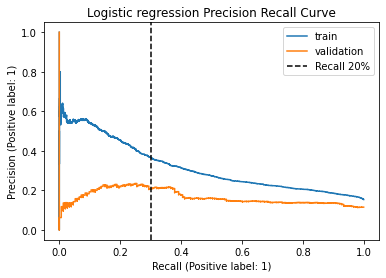

In [83]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
precision3, recall3, thresholds3 = precision_recall_curve(yq2valid, yvalid_preds_proba)
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(yq2train, ytrain_preds_proba)

plt.figure()
ax =plt.gca()
PrecisionRecallDisplay.from_predictions(yq2train,ytrain_preds_proba, ax=ax,label="train")
PrecisionRecallDisplay.from_predictions(yq2valid,yvalid_preds_proba, ax=ax,label="validation")

plt.title("Logistic regression Precision Recall Curve")
#precision_at_recall2 = np.interp(x= 0.3,xp = precision2[int(0.1*len(recall2)):int(0.8*len(recall2))],fp = recall2[int(0.1*len(recall2)):int(0.8*len(recall2))])
#precision_at_recall3 = np.interp(x= 0.3,xp = precision3[(precision3<0.9) & (precision3>0.05)],fp = recall3[(precision3<0.9) & (precision3>0.05)])
#precision_at_recall3_t = np.interp(x= 0.3,xp = precision3_t[(precision3_t<0.9) & (precision3_t>0.05)],fp = recall3_t[(precision3_t<0.9) & (precision3_t>0.05)])
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall 30% -Validation = {np.around(precision_at_recall3*100,2)}%")
#plt.axhline(precision_at_recall3_t,color='green',linestyle = '--',label = f"Precision at Recall 30% -Train= {np.around(precision_at_recall3_t*100,2)}%")
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 20%')
plt.legend()
plt.show()

The model might be overfitting to the training set. The validation set with new students does less well (drop in precision at recall = 30% to 21% from )

In [47]:
coefficients = pd.Series(logreg.coef_[0],index=Xq2train.columns)
coefficients.abs().sort_values(ascending=False).head(20)

avgp_forgot_day     1.596254
history_frac        1.200441
avg_history_frac    0.736440
mod_x0_*pers        0.490897
delta               0.459096
105                 0.380930
simoverdiff         0.371879
pos_x0_ij           0.366009
291                 0.351837
259                 0.349811
mod_x0_subj         0.339994
mod_x0_p2           0.325353
166                 0.312539
168                 0.311131
245                 0.298684
pos_x0_vbhaver      0.298604
240                 0.296082
213                 0.280758
275                 0.279963
mod_x0_pos          0.273931
dtype: float64

Average precision is around 0.21 for the validation set. There is no improvement over the word-based features alone. 

### <font color='cornflowerblue' size=3>Decision trees</font>

In [48]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

classweight_vals = ['balanced',{0:0.01,1:0.99}]
maxdepth_vals = [2,10]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['max_depth'] = maxdepth_vals


scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(dtree, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=3,refit=False)

gridsearch_obj.fit(Xq2_train,yq2train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END class_weight=balanced, max_depth=2; accuracy: (test=0.837) average_precision: (test=0.160) f1: (test=0.052) recall: (test=0.029) roc_auc: (test=0.522) total time=   1.0s
[CV 2/3] END class_weight=balanced, max_depth=2; accuracy: (test=0.506) average_precision: (test=0.245) f1: (test=0.331) recall: (test=0.797) roc_auc: (test=0.674) total time=   1.0s
[CV 3/3] END class_weight=balanced, max_depth=2; accuracy: (test=0.523) average_precision: (test=0.242) f1: (test=0.317) recall: (test=0.723) roc_auc: (test=0.653) total time=   1.0s
[CV 1/3] END class_weight=balanced, max_depth=10; accuracy: (test=0.621) average_precision: (test=0.157) f1: (test=0.238) recall: (test=0.387) roc_auc: (test=0.517) total time=   4.3s
[CV 2/3] END class_weight=balanced, max_depth=10; accuracy: (test=0.568) average_precision: (test=0.184) f1: (test=0.303) recall: (test=0.614) roc_auc: (test=0.581) total time=   4.4s
[CV 3/3] END class_weig

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', {0: 0.01, 1: 0.99}],
                         'max_depth': [2, 10]},
             refit=False,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=3)

In [49]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_max_depth','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_class_weight,param_max_depth,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,balanced,2,0.97,0.03,0.62,0.22,0.62,0.23,0.52
1,balanced,10,4.29,0.03,0.60,0.19,0.57,0.28,0.51
2,"{0: 0.01, 1: 0.99}",2,0.95,0.03,0.16,0.20,0.59,0.27,1.00
3,"{0: 0.01, 1: 0.99}",10,4.42,0.03,0.23,0.20,0.60,0.27,0.92


A balanced class weight is explored futher:

Using max depth = 2
Using max depth = 3
Using max depth = 4
Using max depth = 5
Using max depth = 6
Using max depth = 7
Using max depth = 8
Using max depth = 9
Using max depth = 10
Using max depth = 11
Using max depth = 12
Using max depth = 13


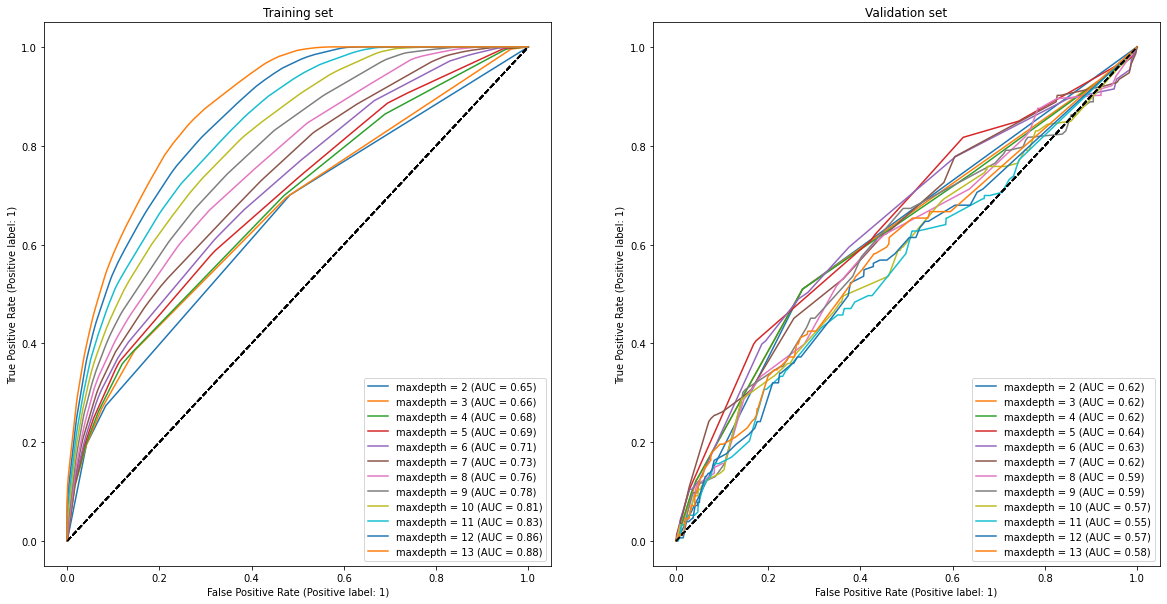

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,\
 roc_auc_score, plot_roc_curve,f1_score,\
  confusion_matrix, classification_report,\
  precision_recall_curve


# creating dictionaries to store metrics for different knn models
valid_acc = dict()
train_acc = dict()

valid_AUC = dict()
train_AUC = dict()

train_cm = dict()
valid_cm = dict()

train_f1 = dict()
valid_f1 = dict()

train_prc = dict()
valid_prc = dict()

train_proba1 = dict()
valid_proba1 = dict()


# create subplots
figs, axes = plt.subplots(1, 2, figsize=(20, 10))



depths = range(2,14)

for d in depths:
  print(f"Using max depth = {d}")
  DTCmodel = DecisionTreeClassifier(max_depth = d,class_weight='balanced') # intitalize a Decision tree classifier model with a new max depth
  DTCmodel.fit(Xq2train,yq2train) 

  # predicting on training and validation sets
  y_train_predicted = DTCmodel.predict(Xq2train) 
  y_valid_predicted = DTCmodel.predict(Xq2valid) 

  # soft predictions on training and validation data
  y_train_proba = DTCmodel.predict_proba(Xq2train) 
  y_valid_proba = DTCmodel.predict_proba(Xq2valid)

  # saving metrics for training and validayion data
  # calculate accuracy
  valid_acc[d] = accuracy_score(yq2valid, y_valid_predicted)
  train_acc[d] = accuracy_score(yq2train,y_train_predicted)

  # getting roc_auc scores for training and validation sets 
  valid_AUC[d] = roc_auc_score(yq2valid, y_valid_proba[:,1])
  train_AUC[d] = roc_auc_score(yq2train, y_train_proba[:,1])

  # getting confusion matrices
  valid_cm[d] = confusion_matrix(yq2valid, y_valid_predicted)
  train_cm[d] = confusion_matrix(yq2train, y_train_predicted)

  # F1 -scores
  valid_f1[d] = f1_score(yq2valid, y_valid_predicted)
  train_f1[d] = f1_score(yq2train, y_train_predicted)

  # precision recall curves
  valid_prc[d] = precision_recall_curve(yq2valid, y_valid_proba[:,1])
  train_prc[d] = precision_recall_curve(yq2train, y_train_proba[:,1])

  # saving probabilities of positive class
  valid_proba1[d] = y_valid_proba[:,1]
  train_proba1[d] = y_train_proba[:,1]

  # plot ROC curve for training and validation sets
  plot_roc_curve(DTCmodel, Xq2train, yq2train, ax=axes[0],name=f"maxdepth = {d}")
  plot_roc_curve(DTCmodel, Xq2valid, yq2valid, ax=axes[1],name=f"maxdepth = {d}")

  # Add line y=x and titls
  for axis_num, plot_title in enumerate(['Training set', 'Validation set']):
    axes[axis_num].plot([0,1], [0,1], color='black', linestyle='--')
    axes[axis_num].set_title(plot_title)

plt.show()



In [59]:
dtree_metrics = pd.DataFrame()
dtree_metrics['valid_accuracy'] = pd.Series(valid_acc)
dtree_metrics['train_accuracy'] = pd.Series(train_acc)
dtree_metrics['valid_AUC'] = pd.Series(valid_AUC)
dtree_metrics['train_AUC'] = pd.Series(train_AUC)
dtree_metrics['valid_f1'] = pd.Series(valid_f1)
dtree_metrics['train_f1'] = pd.Series(train_f1)
dtree_metrics = dtree_metrics.reset_index()
dtree_metrics['Max_depth'] = dtree_metrics['index']
dtree_metrics = dtree_metrics.drop('index',axis=1)
display(np.around(dtree_metrics,2))

,valid_accuracy,train_accuracy,valid_AUC,train_AUC,valid_f1,train_f1,Max_depth
0,0.70,0.54,0.62,0.65,0.28,0.32,2
1,0.86,0.78,0.62,0.66,0.17,0.35,3
2,0.86,0.79,0.62,0.68,0.17,0.35,4
3,0.78,0.67,0.64,0.69,0.29,0.35,5
4,0.77,0.67,0.63,0.71,0.28,0.36,6
5,0.78,0.74,0.62,0.73,0.24,0.39,7
6,0.68,0.69,0.59,0.76,0.22,0.40,8
7,0.68,0.67,0.59,0.78,0.24,0.41,9
8,0.70,0.71,0.57,0.81,0.22,0.44,10
9,0.66,0.69,0.55,0.83,0.22,0.45,11


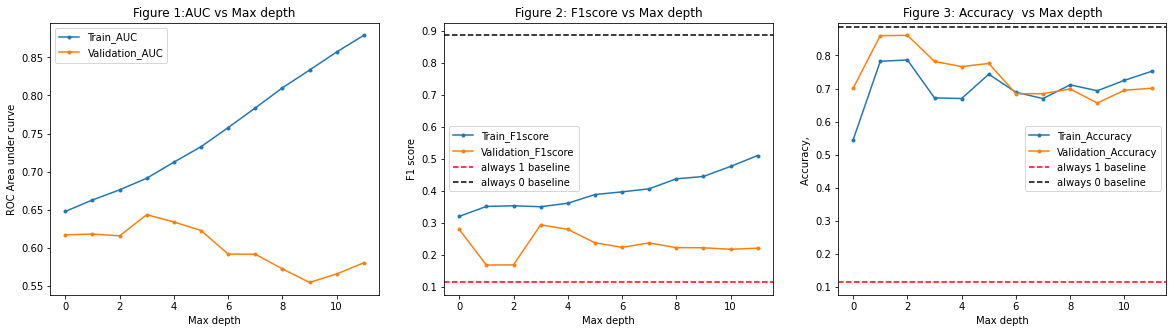

In [60]:
y_valid = yq2valid
y_train = yq2train

plt.subplots(1,3,figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(dtree_metrics['train_AUC'],'.-',label='Train_AUC')
plt.plot(dtree_metrics['valid_AUC'],'.-',label='Validation_AUC')
plt.title("Figure 1:AUC vs Max depth")
plt.xlabel("Max depth")
plt.ylabel("ROC Area under curve")
plt.legend()

plt.subplot(1,3,2)
plt.plot(dtree_metrics['train_f1'],'.-',label='Train_F1score')
plt.plot(dtree_metrics['valid_f1'],'.-',label='Validation_F1score')
# getting accuracy for baseline model that always predicts 1 no matter what.
baseline1_f1 = accuracy_score(y_valid, [1]*y_valid.shape[0])
# getting accuracy for baseline model that always predicts 0 no matter what.
baseline0_f1 = accuracy_score(y_valid, [0]*y_valid.shape[0])
plt.axhline(baseline1_f1,color = 'red',linestyle = '--',label="always 1 baseline")
plt.axhline(baseline0_f1,color = 'black',linestyle = '--',label="always 0 baseline")
plt.xlabel("Max depth")
plt.ylabel("F1 score")
plt.title("Figure 2: F1score vs Max depth")
plt.legend()

plt.subplot(1,3,3)
plt.plot(dtree_metrics['train_accuracy'],'.-',label='Train_Accuracy')
plt.plot(dtree_metrics['valid_accuracy'],'.-',label='Validation_Accuracy')
# getting accuracy for baseline model that always predicts 1 no matter what.
baseline1_acc = accuracy_score(y_valid, [1]*y_valid.shape[0])
# getting accuracy for baseline model that always predicts 0 no matter what.
baseline0_acc = accuracy_score(y_valid, [0]*y_valid.shape[0])
plt.axhline(baseline1_acc,color = 'red',linestyle = '--',label="always 1 baseline")
plt.axhline(baseline0_acc,color = 'black',linestyle = '--',label="always 0 baseline")
plt.xlabel("Max depth")
plt.ylabel("Accuracy, ")
plt.title("Figure 3: Accuracy  vs Max depth")
plt.legend()

plt.show()

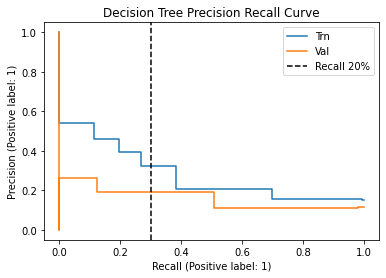

In [68]:
precision3, recall3, thresholds3 = precision_recall_curve(y_valid,valid_proba1[3])
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(y_train,train_proba1[3])
plt.figure()
ax =plt.gca()
PrecisionRecallDisplay.from_predictions(y_train,train_proba1[3], ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(y_valid,valid_proba1[3], ax=ax,label="Val")

plt.title("Decision Tree Precision Recall Curve")
#precision_at_recall2 = np.interp(x= 0.3,xp = precision2[int(0.1*len(recall2)):int(0.8*len(recall2))],fp = recall2[int(0.1*len(recall2)):int(0.8*len(recall2))])
precision_at_recall3 = np.interp(x= 0.3,fp = precision3,xp = recall3)
precision_at_recall3_t = np.interp(x= 0.3,fp = precision3_t,xp = recall3_t)
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall-Val 30% = 20%")
#plt.axhline(precision_at_recall3_t,color='green',linestyle = '--',label = f"Precision at Recall-Trn 30% = 20%")
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 20%')
plt.legend()
plt.show()

The model with student based features only is still at the baseline levels. 

## <font color = 'cornflowerblue' size=4>Ensemble models</font>

### <font color = 'cornflowerblue' size=3>XGBoost</font>

In [75]:
from xgboost import XGBClassifier


XGB_model = XGBClassifier(num_feature = 100,subsample = 0.6)
XGB_model.fit(Xq2_train_mm,yq2train)
print(f"XG Boost train set score: {XGB_model.score(Xq2_train_mm,yq2train)}")
print(f"XG Boost val set score: {XGB_model.score(Xq2_valid_mm,yq2valid)}")

XG Boost train set score: 0.853988283010365
XG Boost val set score: 0.8861607142857143


In [77]:
yq2_train_preds_probs_xgb = XGB_model.predict_proba(Xq2_train_mm)[:,1]
yq2_valid_preds_probs_xgb = XGB_model.predict_proba(Xq2_valid_mm)[:,1]


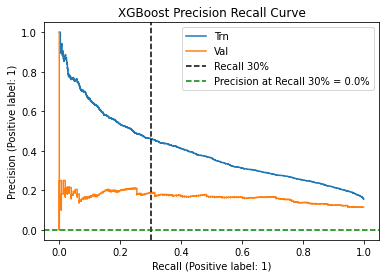

In [82]:
# calculating precision, recall and thresholds for the model
precision3, recall3, thresholds3 = precision_recall_curve(yq2valid, yq2_valid_preds_probs_xgb)
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(yq2train, yq2_train_preds_probs_xgb)


# plotting precision recall curve and calling out precision at 30% recall
plt.figure()
ax =plt.gca()
# plotting precision-recall curve
PrecisionRecallDisplay.from_predictions(yq2train,yq2_train_preds_probs_xgb, ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(yq2valid,yq2_valid_preds_probs_xgb, ax=ax,label="Val")

plt.title("XGBoost Precision Recall Curve")

# interpolating to find precision at recall = 30%
precision_at_recall3 = np.interp(x= 0.3,xp = precision3,fp = recall3)
precision_at_recall3_t = np.interp(x= 0.3,xp = precision3_t,fp = recall3_t)

# plotting vertical line for recall = 0.3
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')

# plotting horizontal line for precision at recall = 0.3, label with rounded precision number
plt.axhline(precision_at_recall2,color='green',linestyle = '--',label = f"Precision at Recall 30% = {np.around(precision_at_recall2*100,2)}%")

plt.legend()
plt.show()

At low recalls, quite a high average precision is reached. That is, if Duolingo wants to ensure people are not bored, and if a word is marked for review, it is likely to be forgotten, precision should be valued over recall. 

With time, the words being missed as forgotten will become more likely to be caught. 

In [85]:
XGB_feature_importances = pd.Series(XGB_model.feature_importances_,index=Xq2train.columns)
XGB_feature_importances.sort_values(ascending=False).head(20)

avg_history_frac         0.019828
avgp_forgot_day          0.015868
history_frac             0.008511
simoverdiff              0.007554
59                       0.007389
113                      0.006753
44                       0.006677
295                      0.006473
256                      0.006234
249                      0.005920
243                      0.005819
245                      0.005730
257                      0.005693
116                      0.005647
210                      0.005634
12                       0.005613
133                      0.005563
69                       0.005509
numwordspracticed_day    0.005417
199                      0.005405
dtype: float32

Ensemble techniques show a slight improvement in precision in the zone where recall is low. It is training to specific cases, possibly for a certain predictable set of students. 

The feature importances are: 
1. avgp_forgot_day (average fraction of forgotten words in the past 3 logged in days), 
2. history_frac (fraction of correct answers on that word specifically), 
3. avg_history_frac (average fraction of correct answers on all words in past 3 days), and 
4. delta (interval of time since last seen that word)

Neural nets

In [86]:
#!nvidia-smi
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [87]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [88]:
!cat /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h |\
grep TF_CUDA_VERSION

cat: /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h: No such file or directory


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Create a new sequential model
model = tf.keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(4, activation="relu"))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

In [ ]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
     
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.3)]
)

In [ ]:
history = model.fit(Xq2_train3d_mm,np.array(yq2_train3d), epochs=150, verbose=1, batch_size=10000,validation_data = (Xq2_valid3d_mm,np.array(yq2_valid3d)))

Epoch 1/150
3/3 [==============================] - 1s 155ms/step - loss: 0.7905 - precision_at_recall_7: 0.1588 - val_loss: 0.7864 - val_precision_at_recall_7: 0.1484
Epoch 2/150
3/3 [==============================] - 0s 22ms/step - loss: 0.7843 - precision_at_recall_7: 0.1583 - val_loss: 0.7802 - val_precision_at_recall_7: 0.1484
Epoch 3/150
3/3 [==============================] - 0s 20ms/step - loss: 0.7782 - precision_at_recall_7: 0.1594 - val_loss: 0.7742 - val_precision_at_recall_7: 0.1484
Epoch 4/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7723 - precision_at_recall_7: 0.1601 - val_loss: 0.7684 - val_precision_at_recall_7: 0.1484
Epoch 5/150
3/3 [==============================] - 0s 16ms/step - loss: 0.7665 - precision_at_recall_7: 0.1592 - val_loss: 0.7627 - val_precision_at_recall_7: 0.1484
Epoch 6/150
3/3 [==============================] - 0s 17ms/step - loss: 0.7609 - precision_at_recall_7: 0.1630 - val_loss: 0.7571 - val_precision_at_recall_7: 0.1487
Epo

In [ ]:
history.history.keys()

dict_keys(['loss', 'precision_at_recall_7', 'val_loss', 'val_precision_at_recall_7'])

In [ ]:
history = model.fit(Xq2_train3d_mm,np.array(yq2_train3d), epochs=80, verbose=1, batch_size=10000,validation_data = (Xq2_valid3d_mm,np.array(yq2_valid3d)))

Epoch 1/80
3/3 [==============================] - 0s 34ms/step - loss: 0.4003 - precision_at_recall_7: 0.3228 - val_loss: 0.4015 - val_precision_at_recall_7: 0.2652
Epoch 2/80
3/3 [==============================] - 0s 15ms/step - loss: 0.4002 - precision_at_recall_7: 0.3229 - val_loss: 0.4015 - val_precision_at_recall_7: 0.2629
Epoch 3/80
3/3 [==============================] - 0s 15ms/step - loss: 0.4001 - precision_at_recall_7: 0.3232 - val_loss: 0.4014 - val_precision_at_recall_7: 0.2635
Epoch 4/80
3/3 [==============================] - 0s 16ms/step - loss: 0.4001 - precision_at_recall_7: 0.3226 - val_loss: 0.4014 - val_precision_at_recall_7: 0.2629
Epoch 5/80
3/3 [==============================] - 0s 15ms/step - loss: 0.4000 - precision_at_recall_7: 0.3225 - val_loss: 0.4014 - val_precision_at_recall_7: 0.2653
Epoch 6/80
3/3 [==============================] - 0s 15ms/step - loss: 0.4000 - precision_at_recall_7: 0.3234 - val_loss: 0.4014 - val_precision_at_recall_7: 0.2659
Epoch 7/80

In [ ]:
plt.plot(history.history['precision_at_recall_7'])
plt.plot(history.history['val_precision_at_recall_7'])
plt.title('Precision at Recall = 0.3 vs Epoch number')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

NameError: ignored

In [ ]:
yq2_valid_preds_probs_nn = model.predict(Xq2_valid3d_mm)
# calculating precision, recall and thresholds for the model
precision2, recall2, thresholds2 = precision_recall_curve(yq2_valid3d, yq2_valid_preds_probs_nn)

# plotting precision recall curve and calling out precision at 30% recall
plt.figure()
ax =plt.gca()
# plotting precision-recall curve
PrecisionRecallDisplay.from_predictions(yq2_valid3d,yq2_valid_preds_probs_nn, ax=ax)
plt.title("Neural Net Precision Recall Curve")

# interpolating to find precision at recall = 30%
precision_at_recall2 = np.interp(x= 0.29,xp = precision2,fp = recall2)

# plotting vertical line for recall = 0.3
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')

# plotting horizontal line for precision at recall = 0.3, label with rounded precision number
plt.axhline(precision_at_recall2,color='green',linestyle = '--',label = f"Precision at Recall 30% = {np.around(precision_at_recall2*100,2)}%")

plt.legend()
plt.show()

NameError: ignored

In [ ]:
import joblib
joblib.dump(model,path_name+"studentfeaturesonly_nn1")

INFO:tensorflow:Assets written to: ram://4af22c36-97c6-4a93-af26-69129b1d1c21/assets


['/content/drive/MyDrive/studentfeaturesonly_nn1']

Preprocessing student based features for Q2test (unseen students) and Q3 test sets (new languages).

In [ ]:
# loading q2 test set
q2test = decompress_pickle(path_name+"Q2TEST.pbz2") 

# computing date
q2test['Date'] = q2test['Datetime'].dt.date

# getting aggregates for each user
userdates = q2test.groupby(['user_id','Date']).agg(numseen_day = ('session_seen','sum'), avg_history_frac = ('history_frac','mean'),avg_history_seen = ('history_seen','mean'),avgp_forgot_day = ('p_forgot_bin','mean'),numwordspracticed_day = ('lexeme_id',lambda x: len(x.unique())), numcorrect_day = ('session_correct','sum'), numquizzes_day = ('session_seen','count'), avgdelta_day = ('delta','mean'), avgactivesessions = ('timestamp',lambda x: len(x.unique())), 
                                     mintimestamp = ('timestamp','min'),maxtimestamp = ('timestamp','max'))

# computing duration from max and min timestamps
userdates['duration'] = userdates['maxtimestamp'] - userdates['mintimestamp']
userdates = userdates.drop(['mintimestamp','maxtimestamp'],axis=1)
userdates = userdates.reset_index()

user_date_tup = q2test[['user_id','Date']].apply(lambda x: frozenset([x[0],str(x[1])]), axis=1)
q2test['user_date_tup'] = user_date_tup 

In [ ]:
numdaysloggedin = userdates.groupby('user_id')['Date'].count()

In [ ]:
numberdays_history = 11

#Users with x number of days logged in
users_withxsessions = numdaysloggedin[numdaysloggedin==numberdays_history].index

# aggregates for each date for users with x number of log in days
Four = userdates.loc[userdates['user_id'].isin(users_withxsessions),:]

# rank dates for each user
Four['daterank'] = Four.groupby('user_id')['Date'].rank()

# calculate interval between days
Four['Prev_Date'] = Four.groupby('user_id')['Date'].shift(1)
Four['Deltaday'] = Four['Date'] - Four['Prev_Date']

# convert to integer
Four['Deltaday'] = Four['Deltaday'].dt.days

# get aggregate features for 1 to x-1 dats
Fouraggs = Four.loc[Four['daterank']<numberdays_history].groupby('user_id')[['avgp_forgot_day','avg_history_frac','numwordspracticed_day','avgdelta_day']].mean()


# get xth date for each user 
fourthrankdates = Four.loc[Four['daterank']==numberdays_history,['user_id','Date']]

# couple user_id and the xth date
fourthrankdates['user_date_tup'] = fourthrankdates[['user_id','Date']].apply(lambda x:frozenset([x[0],str(x[1])]),axis=1)

# join the aggregate features to the fourth dates
fourthrankdates_features = pd.merge(left = fourthrankdates, right = Fouraggs, left_on = 'user_id',right_index=True) 

# filter out only the records of xth date 
fourthday = q2test.loc[q2test['user_date_tup'].isin(fourthrankdates_features['user_date_tup']),:]

# joining with main dataframe records based on user_id
q2test11d_sfonly = pd.merge(left = fourthday,right =fourthrankdates_features, left_on = 'user_id',right_on= 'user_id')

# saving the complete dataframe for further preprocessing later:
compressed_pickle(path_name+"Q2test11dayhist",q2test11d_sfonly)





In [ ]:
q2test11d_sfonly.shape

(3913, 25)

Doing the same with Q3: English to German:

In [ ]:
# loading q2 test set
q3test_en_to_de = decompress_pickle(path_name+"Q3TEST_en_to_de.pbz2") 

# computing date
q3test_en_to_de['Date'] = q3test_en_to_de['Datetime'].dt.date

# getting aggregates for each user
userdates = q3test_en_to_de.groupby(['user_id','Date']).agg(numseen_day = ('session_seen','sum'), avg_history_frac = ('history_frac','mean'),avg_history_seen = ('history_seen','mean'),avgp_forgot_day = ('p_forgot_bin','mean'),numwordspracticed_day = ('lexeme_id',lambda x: len(x.unique())), numcorrect_day = ('session_correct','sum'), numquizzes_day = ('session_seen','count'), avgdelta_day = ('delta','mean'), avgactivesessions = ('timestamp',lambda x: len(x.unique())), 
                                     mintimestamp = ('timestamp','min'),maxtimestamp = ('timestamp','max'))

# computing duration from max and min timestamps
userdates['duration'] = userdates['maxtimestamp'] - userdates['mintimestamp']
userdates = userdates.drop(['mintimestamp','maxtimestamp'],axis=1)
userdates = userdates.reset_index()

user_date_tup = q3test_en_to_de[['user_id','Date']].apply(lambda x: frozenset([x[0],str(x[1])]), axis=1)
q3test_en_to_de['user_date_tup'] = user_date_tup 

In [ ]:
numdaysloggedin = userdates.groupby('user_id')['Date'].count()

In [ ]:
numberdays_history = 11

#Users with x number of days logged in
users_withxsessions = numdaysloggedin[numdaysloggedin==numberdays_history].index

# aggregates for each date for users with x number of log in days
Four = userdates.loc[userdates['user_id'].isin(users_withxsessions),:]

# rank dates for each user
Four['daterank'] = Four.groupby('user_id')['Date'].rank()

# calculate interval between days
Four['Prev_Date'] = Four.groupby('user_id')['Date'].shift(1)
Four['Deltaday'] = Four['Date'] - Four['Prev_Date']

# convert to integer
Four['Deltaday'] = Four['Deltaday'].dt.days

# get aggregate features for 1 to x-1 dats
Fouraggs = Four.loc[Four['daterank']<numberdays_history].groupby('user_id')[['avgp_forgot_day','avg_history_frac','numwordspracticed_day','avgdelta_day']].mean()


# get xth date for each user 
fourthrankdates = Four.loc[Four['daterank']==numberdays_history,['user_id','Date']]

# couple user_id and the xth date
fourthrankdates['user_date_tup'] = fourthrankdates[['user_id','Date']].apply(lambda x:frozenset([x[0],str(x[1])]),axis=1)

# join the aggregate features to the fourth dates
fourthrankdates_features = pd.merge(left = fourthrankdates, right = Fouraggs, left_on = 'user_id',right_index=True) 

# filter out only the records of xth date 
fourthday = q3test_en_to_de.loc[q3test_en_to_de['user_date_tup'].isin(fourthrankdates_features['user_date_tup']),:]

# joining with main dataframe records based on user_id
q3testentode11d_sfonly = pd.merge(left = fourthday,right =fourthrankdates_features, left_on = 'user_id',right_on= 'user_id')

# saving the complete dataframe for further preprocessing later:
compressed_pickle(path_name+"Q3test_en_to_de_11dayhist",q3testentode11d_sfonly)





In [ ]:
q3testentode11d_sfonly.shape

(3212, 25)

Repeating process for Q3 Italian to English

In [ ]:
# loading q2 test set
q3test_it_to_en = decompress_pickle(path_name+"Q3TEST_it_to_en.pbz2") 

# computing date
q3test_it_to_en['Date'] = q3test_it_to_en['Datetime'].dt.date

# getting aggregates for each user
userdates = q3test_it_to_en.groupby(['user_id','Date']).agg(numseen_day = ('session_seen','sum'), avg_history_frac = ('history_frac','mean'),avg_history_seen = ('history_seen','mean'),avgp_forgot_day = ('p_forgot_bin','mean'),numwordspracticed_day = ('lexeme_id',lambda x: len(x.unique())), numcorrect_day = ('session_correct','sum'), numquizzes_day = ('session_seen','count'), avgdelta_day = ('delta','mean'), avgactivesessions = ('timestamp',lambda x: len(x.unique())), 
                                     mintimestamp = ('timestamp','min'),maxtimestamp = ('timestamp','max'))

# computing duration from max and min timestamps
userdates['duration'] = userdates['maxtimestamp'] - userdates['mintimestamp']
userdates = userdates.drop(['mintimestamp','maxtimestamp'],axis=1)
userdates = userdates.reset_index()

user_date_tup = q3test_it_to_en[['user_id','Date']].apply(lambda x: frozenset([x[0],str(x[1])]), axis=1)
q3test_it_to_en['user_date_tup'] = user_date_tup 

In [ ]:
numdaysloggedin = userdates.groupby('user_id')['Date'].count()

In [ ]:
numberdays_history = 11

#Users with x number of days logged in
users_withxsessions = numdaysloggedin[numdaysloggedin==numberdays_history].index

# aggregates for each date for users with x number of log in days
Four = userdates.loc[userdates['user_id'].isin(users_withxsessions),:]

# rank dates for each user
Four['daterank'] = Four.groupby('user_id')['Date'].rank()

# calculate interval between days
Four['Prev_Date'] = Four.groupby('user_id')['Date'].shift(1)
Four['Deltaday'] = Four['Date'] - Four['Prev_Date']

# convert to integer
Four['Deltaday'] = Four['Deltaday'].dt.days

# get aggregate features for 1 to x-1 dats
Fouraggs = Four.loc[Four['daterank']<numberdays_history].groupby('user_id')[['avgp_forgot_day','avg_history_frac','numwordspracticed_day','avgdelta_day']].mean()


# get xth date for each user 
fourthrankdates = Four.loc[Four['daterank']==numberdays_history,['user_id','Date']]

# couple user_id and the xth date
fourthrankdates['user_date_tup'] = fourthrankdates[['user_id','Date']].apply(lambda x:frozenset([x[0],str(x[1])]),axis=1)

# join the aggregate features to the fourth dates
fourthrankdates_features = pd.merge(left = fourthrankdates, right = Fouraggs, left_on = 'user_id',right_index=True) 

# filter out only the records of xth date 
fourthday = q3test_it_to_en.loc[q3test_it_to_en['user_date_tup'].isin(fourthrankdates_features['user_date_tup']),:]

# joining with main dataframe records based on user_id
q3testittoen11d_sfonly = pd.merge(left = fourthday,right =fourthrankdates_features, left_on = 'user_id',right_on= 'user_id')

# saving the complete dataframe for further preprocessing later:
compressed_pickle(path_name+"Q3test_it_to_en_11dayhist",q3testittoen11d_sfonly)





In [ ]:
q3testittoen11d_sfonly.shape

(1417, 25)

In [ ]:
np.random.seed(123)
lduserstrain = np.random.choice(lastdayusers,int(0.9*len(lastdayusers)),replace=False) # sample from list without replacement
ldusersvalid = set(lastdayusers).difference(lduserstrain)

NameError: ignored

In [ ]:
len(lduserstrain),len(ldusersvalid)

(7278, 809)

In [ ]:
q2train.shape

(9866089, 18)

In [ ]:
q2train['Date'].values[0]

datetime.date(2013, 2, 28)

In [ ]:
datetime.strptime('12032013',"%d%m%Y").date()

datetime.date(2013, 3, 12)

In [ ]:
userdates = q2train.loc[(q2train['Date']!=datetime.strptime('12032013', "%d%m%Y").date()) & \
                         (q2train['user_id'].isin(lastdayusers))].groupby(['user_id','Date']).agg(numseen_day = ('session_seen','sum'), avgp_forgot_day = ('p_forgot_bin','mean'),numwordspracticed_day = ('lexeme_id',lambda x: len(x.unique())), numcorrect_day = ('session_correct','sum'), numquizzes_day = ('session_seen','count'), avgdelta_day = ('delta','mean'), avgactivesessions = ('timestamp',lambda x: len(x.unique())), 
                                     mintimestamp = ('timestamp','min'),maxtimestamp = ('timestamp','max'))

In [ ]:
userdates

numseen_day  avgp_forgot_day  numwordspracticed_day  \
user_id Date                                                              
u:-Md   2013-03-02          150         0.200000                     40   
        2013-03-03           58         0.384615                     13   
        2013-03-04           68         0.238095                     14   
        2013-03-05           43         0.333333                      3   
        2013-03-08           92         0.064516                     34   
...                         ...              ...                    ...   
u:zBA   2013-03-10           45         0.000000                     26   
        2013-03-11          171         0.262626                     83   
u:zT8   2013-03-05           29         0.038462                     26   
u:zfs   2013-03-11           39         0.080000                     25   
u:zpJ   2013-03-10           18         0.142857                      7   

                    numcorrect_day  numquizzes_day  avgdelta_day  \
user_id Date                                                       
u:-Md   2013-03-02             140              40  6.453903e+05   
        2013-03-03              52              13  3.344615e+02   
        2013-03-04              63              21  6.039000e+04   
        2013-03-05              41               6  1.128245e+05   
        2013-03-08              88              62  6.252394e+04   
...                            ...             ...           ...   
u:zBA   2013-03-10              45              26  1.352965e+06   
        2013-03-11             145              99  1.296227e+06   
u:zT8   2013-03-05              28              26  5.283672e+06   
u:zfs   2013-03-11              37              25  2.516135e+06   
u:zpJ   2013-03-10              17               7  1.833400e+04   

                    avgactivesessions  mintimestamp  maxtimestamp  
user_id Date                                                       
u:-Md   2013-03-02                  5    1362265480    1362268433  
        2013-03-03                  2    1362268873    1362270267  
        2013-03-04                  3    1362360533    1362361189  
        2013-03-05                  2    1362494998    1362495188  
        2013-03-08                  4    1362709676    1362758874  
...                               ...           ...           ...  
u:zBA   2013-03-10                  1    1362945049    1362945049  
        2013-03-11                  4    1362992278    1363010433  
u:zT8   2013-03-05                  1    1362523860    1362523860  
u:zfs   2013-03-11                  1    1362980193    1362980193  
u:zpJ   2013-03-10                  1    1362940066    1362940066  

[31434 rows x 9 columns]

In [ ]:
userdates['duration'] = userdates['maxtimestamp'] - userdates['mintimestamp']
userdates = userdates.drop(['mintimestamp','maxtimestamp'],axis=1)

In [ ]:
userdates = userdates.reset_index()
userdates.head()

,user_id,Date,numseen_day,avgp_forgot_day,numwordspracticed_day,numcorrect_day,numquizzes_day,avgdelta_day,avgactivesessions,duration
0,u:-Md,2013-03-02,150,0.200000,40,140,40,645390.300000,5,2953
1,u:-Md,2013-03-03,58,0.384615,13,52,13,334.461538,2,1394
2,u:-Md,2013-03-04,68,0.238095,14,63,21,60390.000000,3,656
3,u:-Md,2013-03-05,43,0.333333,3,41,6,112824.500000,2,190
4,u:-Md,2013-03-08,92,0.064516,34,88,62,62523.935484,4,49198


In [ ]:
userdates.head(7)

,user_id,Date,numseen_day,avgp_forgot_day,numwordspracticed_day,numcorrect_day,numquizzes_day,avgdelta_day,avgactivesessions,duration
0,u:-Md,2013-03-02,150,0.200000,40,140,40,645390.300000,5,2953
1,u:-Md,2013-03-03,58,0.384615,13,52,13,334.461538,2,1394
2,u:-Md,2013-03-04,68,0.238095,14,63,21,60390.000000,3,656
3,u:-Md,2013-03-05,43,0.333333,3,41,6,112824.500000,2,190
4,u:-Md,2013-03-08,92,0.064516,34,88,62,62523.935484,4,49198
5,u:-Md,2013-03-10,251,0.075221,72,234,226,135581.641593,8,60209
6,u:-Md,2013-03-11,103,0.161765,66,92,68,113820.779412,4,4091


Aggregating the features for each day, and getting mean, variance, and number of days logged in, averag delta day, std dev in delta day

In [ ]:
useraggs = userdates.groupby('user_id').describe()

In [ ]:
newcolumns = [str(x[0])+'_'+str(x[1]) for x in useraggs.columns]
useraggs.columns = newcolumns

In [ ]:
useraggs.head()

,numseen_day_count,numseen_day_mean,numseen_day_std,numseen_day_min,numseen_day_25%,numseen_day_50%,numseen_day_75%,numseen_day_max,avgp_forgot_day_count,avgp_forgot_day_mean,...,avgactivesessions_75%,avgactivesessions_max,duration_count,duration_mean,duration_std,duration_min,duration_25%,duration_50%,duration_75%,duration_max
user_id,,,,,,,,,,,,,,,,,,,,,
u:-Md,7.0,109.285714,71.655924,43.0,63.00,92.0,126.50,251.0,7.0,0.208221,...,4.50,8.0,7.0,16955.857143,26015.781771,190.0,1025.00,2953.0,26644.5,60209.0
u:-TS,4.0,29.000000,11.045361,16.0,25.00,28.5,32.50,43.0,4.0,0.123810,...,2.00,2.0,4.0,340.750000,272.261363,0.0,240.75,349.5,449.5,664.0
u:-b,10.0,395.000000,274.475257,63.0,221.25,351.0,501.75,1026.0,10.0,0.119960,...,13.75,40.0,10.0,50399.400000,41267.482865,241.0,3319.75,76608.5,84985.5,85701.0
u:0P4,2.0,13.000000,15.556349,2.0,7.50,13.0,18.50,24.0,2.0,0.145833,...,2.50,3.0,2.0,78.000000,110.308658,0.0,39.00,78.0,117.0,156.0
u:0Q_,9.0,151.111111,103.078180,55.0,80.00,100.0,203.00,328.0,9.0,0.160069,...,7.00,10.0,9.0,3389.888889,3652.653332,901.0,1197.00,2485.0,3026.0,12735.0


In [ ]:
useraggs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8087 entries, u:-Md to u:zpJ
Data columns (total 64 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numseen_day_count            8087 non-null   float64
 1   numseen_day_mean             8087 non-null   float64
 2   numseen_day_std              6111 non-null   float64
 3   numseen_day_min              8087 non-null   float64
 4   numseen_day_25%              8087 non-null   float64
 5   numseen_day_50%              8087 non-null   float64
 6   numseen_day_75%              8087 non-null   float64
 7   numseen_day_max              8087 non-null   float64
 8   avgp_forgot_day_count        8087 non-null   float64
 9   avgp_forgot_day_mean         8087 non-null   float64
 10  avgp_forgot_day_std          6111 non-null   float64
 11  avgp_forgot_day_min          8087 non-null   float64
 12  avgp_forgot_day_25%          8087 non-null   float64
 13  avgp_forgot_day_50

The standard deviation columns have null values. days_delta columns also have some null values (single log ins). the rest are fully filled. 

Since we already have min, 25%, median and 75th percentile values, the 'std' columns are deleted. 

we can also delete all but one count columns.

In [ ]:
columns_with_na = [col for col in useraggs.columns if useraggs[col].isna().any()]
columns_with_na

['numseen_day_std',
 'avgp_forgot_day_std',
 'numwordspracticed_day_std',
 'numcorrect_day_std',
 'numquizzes_day_std',
 'avgdelta_day_std',
 'avgactivesessions_std',
 'duration_std']

In [ ]:
useraggs = useraggs.drop(columns_with_na,axis=1)

In [ ]:
useraggs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8087 entries, u:-Md to u:zpJ
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numseen_day_count            8087 non-null   float64
 1   numseen_day_mean             8087 non-null   float64
 2   numseen_day_min              8087 non-null   float64
 3   numseen_day_25%              8087 non-null   float64
 4   numseen_day_50%              8087 non-null   float64
 5   numseen_day_75%              8087 non-null   float64
 6   numseen_day_max              8087 non-null   float64
 7   avgp_forgot_day_count        8087 non-null   float64
 8   avgp_forgot_day_mean         8087 non-null   float64
 9   avgp_forgot_day_min          8087 non-null   float64
 10  avgp_forgot_day_25%          8087 non-null   float64
 11  avgp_forgot_day_50%          8087 non-null   float64
 12  avgp_forgot_day_75%          8087 non-null   float64
 13  avgp_forgot_day_ma

In [ ]:
countcols = [col for col in useraggs if col.endswith('_count')]
countcols

['numseen_day_count',
 'avgp_forgot_day_count',
 'numwordspracticed_day_count',
 'numcorrect_day_count',
 'numquizzes_day_count',
 'avgdelta_day_count',
 'avgactivesessions_count',
 'duration_count']

In [ ]:
useraggs = useraggs.drop(countcols[1:],axis=1)
useraggs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8087 entries, u:-Md to u:zpJ
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   numseen_day_count           8087 non-null   float64
 1   numseen_day_mean            8087 non-null   float64
 2   numseen_day_min             8087 non-null   float64
 3   numseen_day_25%             8087 non-null   float64
 4   numseen_day_50%             8087 non-null   float64
 5   numseen_day_75%             8087 non-null   float64
 6   numseen_day_max             8087 non-null   float64
 7   avgp_forgot_day_mean        8087 non-null   float64
 8   avgp_forgot_day_min         8087 non-null   float64
 9   avgp_forgot_day_25%         8087 non-null   float64
 10  avgp_forgot_day_50%         8087 non-null   float64
 11  avgp_forgot_day_75%         8087 non-null   float64
 12  avgp_forgot_day_max         8087 non-null   float64
 13  numwordspracticed_day_mean  8087 

In [ ]:
useraggs.head()

,numseen_day_count,numseen_day_mean,numseen_day_min,numseen_day_25%,numseen_day_50%,numseen_day_75%,numseen_day_max,avgp_forgot_day_mean,avgp_forgot_day_min,avgp_forgot_day_25%,...,avgactivesessions_25%,avgactivesessions_50%,avgactivesessions_75%,avgactivesessions_max,duration_mean,duration_min,duration_25%,duration_50%,duration_75%,duration_max
user_id,,,,,,,,,,,,,,,,,,,,,
u:-Md,7.0,109.285714,43.0,63.00,92.0,126.50,251.0,0.208221,0.064516,0.118493,...,2.50,4.0,4.50,8.0,16955.857143,190.0,1025.00,2953.0,26644.5,60209.0
u:-TS,4.0,29.000000,16.0,25.00,28.5,32.50,43.0,0.123810,0.066667,0.123810,...,1.75,2.0,2.00,2.0,340.750000,0.0,240.75,349.5,449.5,664.0
u:-b,10.0,395.000000,63.0,221.25,351.0,501.75,1026.0,0.119960,0.030303,0.069311,...,8.25,11.5,13.75,40.0,50399.400000,241.0,3319.75,76608.5,84985.5,85701.0
u:0P4,2.0,13.000000,2.0,7.50,13.0,18.50,24.0,0.145833,0.000000,0.072917,...,1.50,2.0,2.50,3.0,78.000000,0.0,39.00,78.0,117.0,156.0
u:0Q_,9.0,151.111111,55.0,80.00,100.0,203.00,328.0,0.160069,0.045267,0.128205,...,4.00,5.0,7.00,10.0,3389.888889,901.0,1197.00,2485.0,3026.0,12735.0


In [ ]:
useraggs_train = useraggs.loc[useraggs.index.isin(lduserstrain),:]
useraggs_train.shape

(7278, 49)

In [ ]:
useraggs_valid = useraggs.loc[useraggs.index.isin(ldusersvalid),:]
useraggs_valid.shape

(809, 49)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
stdscaler1 = StandardScaler()
useraggs_train_ss = stdscaler1.fit_transform(useraggs_train)

In [ ]:
pca1 = PCA(n_components=0.95)
useraggs_train_pca = pca1.fit_transform(useraggs_train_ss)

In [ ]:
useraggs_train_fs1 = pd.DataFrame(useraggs_train_pca,index=useraggs_train.index)
useraggs_train_fs1.head()

,0,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,,
u:-Md,0.170940,-1.496617,-0.142280,-1.486294,-0.229469,0.244450,1.167827,0.260918,-0.075711,-0.420590,-0.091015
u:-b,15.504204,-2.416625,2.851317,-6.495230,0.154530,-3.440906,-0.802048,-0.070860,-1.128886,0.120305,-1.143222
u:0P4,-5.386465,15.145130,13.598454,-3.194898,-1.759389,2.507292,0.027032,0.254940,0.141125,0.306528,0.157454
u:0Q_,0.728589,-1.219469,0.087906,-0.405955,0.715012,1.964349,0.419140,0.189662,0.950885,-0.817698,-0.490016
u:0vf,-5.411624,8.070827,5.164176,-2.281577,-0.539435,1.224662,0.946369,0.328358,1.440568,0.868327,0.372970


In [ ]:
useraggs_train_fs1.isna().any().sum()

0

In [ ]:
pca1.explained_variance_ratio_

array([0.46878792, 0.12464406, 0.10143785, 0.09023501, 0.06798701,
       0.03867215, 0.01841931, 0.01714067, 0.01284262, 0.00972742,
       0.00768135])

Columns reduced from 49 to 10 for 95% explained variance. 

In [ ]:
useraggs_valid_ss = stdscaler1.transform(useraggs_valid)
useraggs_valid_pca = pca1.transform(useraggs_valid_ss)

In [ ]:
useraggs_valid_pca.shape

(809, 11)

In [ ]:
# get test set and process with PCA
useraggs_valid_fs1 = pd.DataFrame(useraggs_valid_pca,index=useraggs_valid.index)
useraggs_valid_fs1.head()

,0,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,,
u:-TS,-3.259923,-0.306223,1.078792,0.989610,0.125466,0.320227,-0.284303,0.105851,0.108265,0.042495,-0.209451
u:0Tt,-1.329534,1.666386,-0.358854,1.384260,0.947385,-1.288181,-0.459112,-0.116279,-0.570418,-0.231401,0.001497
u:ASj,6.985753,1.455629,-0.328161,-2.474456,2.414529,-2.041266,-2.298069,6.404933,0.502195,-0.920645,-0.244115
u:CD8,-2.505175,0.544651,-2.142974,-0.335249,0.891865,-0.098025,-0.590785,-0.218344,-0.089183,0.203863,-0.193171
u:DsW,-3.168699,14.332281,12.465868,-2.239985,-1.367413,1.990018,0.111176,0.110244,-0.318106,0.110759,-0.275957


Applying the same transformations on the test set.

In [ ]:
q2test = decompress_pickle(path_name+"Q2TEST.pbz2") 

Quick sanity checks to ensure no duplication after i joined the training and test sets. (There shouldn't be any, but still..)

In [ ]:
q2test.duplicated().sum()

0

In [ ]:
q2test.head()

,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_forgot_bin,simoverdiff,lang_frozenset,Datetime,delta_days,history_frac
64,1362082493,1469,u:g3WM,pt,en,57408f89412af98111a2f87c0ab41b22,tu/tu<prn><tn><p2><mf><sg>,48,48,1,1,0,0.0,"(en, pt)",2013-02-28 20:14:53,0.017002,1.000000
65,1362082493,1469,u:g3WM,pt,en,8414835cb39e4315146a59fefdd6d1c6,tem/ter<vblex><pri><p3><sg>,2,2,2,1,1,0.0,"(en, pt)",2013-02-28 20:14:53,0.017002,1.000000
66,1362082493,1469,u:g3WM,pt,en,ecc3feb8e53ce936cef181dd54e7aaca,temos/ter<vblex><pri><p1><pl>,1,1,1,1,0,0.0,"(en, pt)",2013-02-28 20:14:53,0.017002,1.000000
67,1362082493,2184,u:g3WM,pt,en,8d28ba0fa188f1847571467189846dda,tua/teu<det><pos><f><sg>,4,3,1,1,0,0.0,"(en, pt)",2013-02-28 20:14:53,0.025278,0.750000
68,1362082493,1469,u:g3WM,pt,en,4b3613233b3fede2e3e92ac2ef752bf6,leão/leão<n><m><sg>,9,8,1,1,0,0.0,"(en, pt)",2013-02-28 20:14:53,0.017002,0.888889


In [ ]:
q2test['Date'] = q2test['Datetime'].dt.date

There are no ones. We have basically got the all zero baseline. 

This set of features does not suffice to predict student performance. 

Previously we tried a many-word one student model and were able to achieve 0.78 precision with 0.87 recall. This points to student based features being more important than word based features to predicting forgetting a word. 

Plan: 
1. Parse out which students have log ins on the last day of the dataset.
2. Get aggregated student feature data for them alone.
3. split those students into training and testing
4. add those aggregated features to the last date dataset, and split dataset into training and testing.  


Converting timestamp to datetime objects [link](https://stackoverflow.com/questions/9744775/how-to-convert-integer-timestamp-into-a-datetime)

In [ ]:
q2test['Date'].max()

datetime.date(2013, 3, 12)

Last day is Mar 12, 2013. Let us count the students who logged in that day. 

In [ ]:
from datetime import datetime
lastdaylogs_test = q2test.loc[q2test['Date']==datetime.strptime('12032013', "%d%m%Y").date(),:]

notlastdaylogs_test = q2test.loc[q2test['Date']!=datetime.strptime('12032013', "%d%m%Y").date(),:]

In [ ]:
lastdaylogs_test.shape, notlastdaylogs_test.shape

((55134, 18), (1056173, 18))

In [ ]:
lastdayusers_test = lastdaylogs_test['user_id'].unique()

notlastdayusers_test = notlastdaylogs_test['user_id'].unique()

In [ ]:
lastdayusers_test = set(lastdayusers_test).intersection(set(notlastdayusers_test))

In [ ]:
len(lastdayusers_test)

lastdayusers_test = list(lastdayusers_test)

The test set has 1286 students who logged in on the last day. 

Getting aggregate features. 

In [ ]:
userdates_test = q2test.loc[(q2test['Date']!=datetime.strptime('12032013', "%d%m%Y").date()) & \
                         (q2test['user_id'].isin(lastdayusers_test))].groupby(['user_id','Date']).agg(numseen_day = ('session_seen','sum'), avgp_forgot_day = ('p_forgot_bin','mean'),numwordspracticed_day = ('lexeme_id',lambda x: len(x.unique())), numcorrect_day = ('session_correct','sum'), numquizzes_day = ('session_seen','count'), avgdelta_day = ('delta','mean'), avgactivesessions = ('timestamp',lambda x: len(x.unique())), 
                                     mintimestamp = ('timestamp','min'),maxtimestamp = ('timestamp','max'))

In [ ]:
userdates_test

numseen_day  avgp_forgot_day  numwordspracticed_day  \
user_id Date                                                              
u:-Ou   2013-03-04           50         0.081081                     37   
        2013-03-05           29         0.250000                      8   
u:-f2   2013-03-07           54         0.274510                     37   
        2013-03-08          103         0.170000                     78   
        2013-03-11           75         0.183099                     60   
...                         ...              ...                    ...   
u:vAE   2013-03-07           70         0.133333                     15   
        2013-03-11          159         0.210526                     42   
u:z22   2013-03-01           20         0.000000                      7   
        2013-03-03           19         0.000000                      7   
        2013-03-04          154         0.020833                     50   

                    numcorrect_day  numquizzes_day  avgdelta_day  \
user_id Date                                                       
u:-Ou   2013-03-04              47              37  1.638390e+06   
        2013-03-05              27               8  2.250238e+05   
u:-f2   2013-03-07              40              51  2.850728e+06   
        2013-03-08              86             100  1.125697e+06   
        2013-03-11              61              71  1.953370e+06   
...                            ...             ...           ...   
u:vAE   2013-03-07              66              15  1.193889e+07   
        2013-03-11             147              57  9.598828e+04   
u:z22   2013-03-01              20               7  8.461900e+04   
        2013-03-03              19               7  1.231100e+04   
        2013-03-04             152              96  1.595272e+05   

                    avgactivesessions  mintimestamp  maxtimestamp  
user_id Date                                                       
u:-Ou   2013-03-04                  1    1362369181    1362369181  
        2013-03-05                  1    1362453636    1362453636  
u:-f2   2013-03-07                  3    1362651864    1362652148  
        2013-03-08                  4    1362743640    1362744713  
        2013-03-11                  3    1362995246    1362998159  
...                               ...           ...           ...  
u:vAE   2013-03-07                  2    1362691250    1362692167  
        2013-03-11                 10    1363032286    1363035171  
u:z22   2013-03-01                  1    1362155309    1362155309  
        2013-03-03                  1    1362351153    1362351153  
        2013-03-04                  6    1362414138    1362426937  

[3524 rows x 9 columns]

In [ ]:
userdates_test['duration'] = userdates_test['maxtimestamp'] - userdates_test['mintimestamp']
userdates_test = userdates_test.drop(['mintimestamp','maxtimestamp'],axis=1)

In [ ]:
userdates_test = userdates_test.reset_index()
userdates_test.head()

,user_id,Date,numseen_day,avgp_forgot_day,numwordspracticed_day,numcorrect_day,numquizzes_day,avgdelta_day,avgactivesessions,duration
0,u:-Ou,2013-03-04,50,0.081081,37,47,37,1.638390e+06,1,0
1,u:-Ou,2013-03-05,29,0.250000,8,27,8,2.250238e+05,1,0
2,u:-f2,2013-03-07,54,0.274510,37,40,51,2.850728e+06,3,284
3,u:-f2,2013-03-08,103,0.170000,78,86,100,1.125697e+06,4,1073
4,u:-f2,2013-03-11,75,0.183099,60,61,71,1.953370e+06,3,2913


Aggregating the features for each day, and getting mean, variance, and number of days logged in, averag delta day, std dev in delta day

In [ ]:
useraggs_test = userdates_test.groupby('user_id').describe()

In [ ]:
newcolumns = [str(x[0])+'_'+str(x[1]) for x in useraggs_test.columns]
useraggs_test.columns = newcolumns

In [ ]:
useraggs_test.head(7)

,numseen_day_count,numseen_day_mean,numseen_day_std,numseen_day_min,numseen_day_25%,numseen_day_50%,numseen_day_75%,numseen_day_max,avgp_forgot_day_count,avgp_forgot_day_mean,...,avgactivesessions_75%,avgactivesessions_max,duration_count,duration_mean,duration_std,duration_min,duration_25%,duration_50%,duration_75%,duration_max
user_id,,,,,,,,,,,,,,,,,,,,,
u:-Ou,2.0,39.500000,14.849242,29.0,34.25,39.5,44.75,50.0,2.0,0.165541,...,1.00,1.0,2.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
u:-f2,3.0,77.333333,24.583192,54.0,64.50,75.0,89.00,103.0,3.0,0.209203,...,3.50,4.0,3.0,1423.333333,1349.059055,284.0,678.50,1073.0,1993.00,2913.0
u:3Ym,3.0,84.333333,132.228338,6.0,8.00,10.0,123.50,237.0,3.0,0.092377,...,4.00,7.0,3.0,1487.666667,2576.714251,0.0,0.00,0.0,2231.50,4463.0
u:3r4,4.0,24.250000,15.861379,12.0,14.25,19.0,29.00,47.0,4.0,0.228865,...,3.25,7.0,4.0,245.000000,397.402399,0.0,50.25,70.5,265.25,839.0
u:6OE,5.0,28.200000,4.868265,23.0,26.00,27.0,29.00,36.0,5.0,0.426667,...,1.00,1.0,5.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
u:9rx,5.0,194.000000,124.943987,63.0,70.00,205.0,313.00,319.0,5.0,0.206328,...,8.00,13.0,5.0,18261.000000,17539.997278,971.0,1533.00,18818.0,28220.00,41763.0
u:Arp,7.0,54.428571,34.698017,16.0,28.50,44.0,76.00,112.0,7.0,0.149518,...,3.00,6.0,7.0,29802.714286,36411.787129,0.0,233.50,2265.0,66993.50,71900.0


In [ ]:
useraggs_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 904 entries, u:-Ou to u:z22
Data columns (total 64 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numseen_day_count            904 non-null    float64
 1   numseen_day_mean             904 non-null    float64
 2   numseen_day_std              669 non-null    float64
 3   numseen_day_min              904 non-null    float64
 4   numseen_day_25%              904 non-null    float64
 5   numseen_day_50%              904 non-null    float64
 6   numseen_day_75%              904 non-null    float64
 7   numseen_day_max              904 non-null    float64
 8   avgp_forgot_day_count        904 non-null    float64
 9   avgp_forgot_day_mean         904 non-null    float64
 10  avgp_forgot_day_std          669 non-null    float64
 11  avgp_forgot_day_min          904 non-null    float64
 12  avgp_forgot_day_25%          904 non-null    float64
 13  avgp_forgot_day_50%

In [ ]:
useraggs_test = useraggs_test.drop(columns_with_na,axis=1)

In [ ]:
useraggs_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 904 entries, u:-Ou to u:z22
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numseen_day_count            904 non-null    float64
 1   numseen_day_mean             904 non-null    float64
 2   numseen_day_min              904 non-null    float64
 3   numseen_day_25%              904 non-null    float64
 4   numseen_day_50%              904 non-null    float64
 5   numseen_day_75%              904 non-null    float64
 6   numseen_day_max              904 non-null    float64
 7   avgp_forgot_day_count        904 non-null    float64
 8   avgp_forgot_day_mean         904 non-null    float64
 9   avgp_forgot_day_min          904 non-null    float64
 10  avgp_forgot_day_25%          904 non-null    float64
 11  avgp_forgot_day_50%          904 non-null    float64
 12  avgp_forgot_day_75%          904 non-null    float64
 13  avgp_forgot_day_max

In [ ]:
useraggs_test = useraggs_test.drop(countcols[1:],axis=1)
useraggs_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 904 entries, u:-Ou to u:z22
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   numseen_day_count           904 non-null    float64
 1   numseen_day_mean            904 non-null    float64
 2   numseen_day_min             904 non-null    float64
 3   numseen_day_25%             904 non-null    float64
 4   numseen_day_50%             904 non-null    float64
 5   numseen_day_75%             904 non-null    float64
 6   numseen_day_max             904 non-null    float64
 7   avgp_forgot_day_mean        904 non-null    float64
 8   avgp_forgot_day_min         904 non-null    float64
 9   avgp_forgot_day_25%         904 non-null    float64
 10  avgp_forgot_day_50%         904 non-null    float64
 11  avgp_forgot_day_75%         904 non-null    float64
 12  avgp_forgot_day_max         904 non-null    float64
 13  numwordspracticed_day_mean  904 no

In [ ]:
useraggs_test.head()

,numseen_day_count,numseen_day_mean,numseen_day_min,numseen_day_25%,numseen_day_50%,numseen_day_75%,numseen_day_max,avgp_forgot_day_mean,avgp_forgot_day_min,avgp_forgot_day_25%,...,avgactivesessions_25%,avgactivesessions_50%,avgactivesessions_75%,avgactivesessions_max,duration_mean,duration_min,duration_25%,duration_50%,duration_75%,duration_max
user_id,,,,,,,,,,,,,,,,,,,,,
u:-Ou,2.0,39.500000,29.0,34.25,39.5,44.75,50.0,0.165541,0.081081,0.123311,...,1.00,1.0,1.00,1.0,0.000000,0.0,0.00,0.0,0.00,0.0
u:-f2,3.0,77.333333,54.0,64.50,75.0,89.00,103.0,0.209203,0.170000,0.176549,...,3.00,3.0,3.50,4.0,1423.333333,284.0,678.50,1073.0,1993.00,2913.0
u:3Ym,3.0,84.333333,6.0,8.00,10.0,123.50,237.0,0.092377,0.000000,0.055233,...,1.00,1.0,4.00,7.0,1487.666667,0.0,0.00,0.0,2231.50,4463.0
u:3r4,4.0,24.250000,12.0,14.25,19.0,29.00,47.0,0.228865,0.000000,0.083333,...,1.75,2.0,3.25,7.0,245.000000,0.0,50.25,70.5,265.25,839.0
u:6OE,5.0,28.200000,23.0,26.00,27.0,29.00,36.0,0.426667,0.222222,0.222222,...,1.00,1.0,1.00,1.0,0.000000,0.0,0.00,0.0,0.00,0.0


Scaling and transforming

In [ ]:
useraggs_test_ss = stdscaler1.transform(useraggs_test)
useraggs_test_pca = pca1.transform(useraggs_test_ss)
useraggs_test_fs1 = pd.DataFrame(useraggs_test_pca,index=useraggs_test.index)
useraggs_test_fs1.head()

,0,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,,
u:-Ou,-3.031094,-0.326117,0.357300,1.076542,0.483649,-0.183707,-0.229996,-0.357345,0.211035,0.248823,-0.081990
u:-f2,-0.079721,1.282739,0.835591,0.834293,1.214105,-1.686855,-0.440898,0.591430,0.087776,-0.015322,0.189333
u:3Ym,-1.767775,-2.062136,0.879543,0.265254,0.815212,0.626080,-0.842774,-0.718525,0.427625,-0.735642,0.438352
u:3r4,-3.984660,6.105587,5.397861,-1.850987,-0.303064,1.290434,0.615639,0.921749,1.513545,0.411290,0.318483
u:6OE,-5.383812,13.531870,8.218082,-4.269687,-0.751438,1.630927,1.875232,0.448505,1.698948,0.748610,-0.074940


Saving train, validation and test sets.

In [ ]:
compressed_pickle(path_name+"Q2TRAIN_studentfeatures1",useraggs_train_fs1)
compressed_pickle(path_name+"Q2VALID_studentfeatures1",useraggs_valid_fs1)
compressed_pickle(path_name+"Q2TEST_studentfeatures1",useraggs_test_fs1)

Combining with the lastday logs.

In [ ]:
lastdaylogs.head()

,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_forgot_bin,simoverdiff,lang_frozenset,Datetime,delta_days,history_frac,Date
12211568,1363046401,1123854,u:inBD,es,en,4452601308c9aeb4f25f01fb6710ed16,salsa/salsa<n><f><sg>,2,2,1,1,0,0.000159,"(en, es)",2013-03-12 00:00:01,13.007569,1.0,2013-03-12
12211569,1363046401,1125308,u:inBD,es,en,bdb10c2d4f793986f32986d746051a59,fresas/fresa<n><f><pl>,3,3,1,1,0,0.000159,"(en, es)",2013-03-12 00:00:01,13.024398,1.0,2013-03-12
12211570,1363046401,70633,u:inBD,es,en,8d97dc81cb3844281262ee45b3d33f3c,fruta/fruta<n><f><sg>,3,3,1,1,0,0.000159,"(en, es)",2013-03-12 00:00:01,0.817512,1.0,2013-03-12
12211571,1363046401,1123854,u:inBD,es,en,890f121972386ce1dbb811304e774f3f,comida/comida<n><f><sg>,2,2,1,0,1,0.000159,"(en, es)",2013-03-12 00:00:01,13.007569,1.0,2013-03-12
12211572,1363046401,948535,u:inBD,es,en,7d22860d8b51d67c932fe10dfce59dc2,tomate/tomate<n><m><sg>,3,3,1,1,0,0.000159,"(en, es)",2013-03-12 00:00:01,10.978414,1.0,2013-03-12


Combining the student aggregate features 

In [ ]:
q2trainX_sf = lastdaylogs.loc[lastdaylogs['user_id'].isin(lduserstrain), ['delta','user_id','history_seen','history_frac','simoverdiff','lexeme_id']]
q2trainy = lastdaylogs.loc[lastdaylogs['user_id'].isin(lduserstrain), 'p_forgot_bin']
q2validX_sf = lastdaylogs.loc[lastdaylogs['user_id'].isin(ldusersvalid), ['delta','user_id','history_seen','history_frac','simoverdiff','lexeme_id']]
q2validy = lastdaylogs.loc[lastdaylogs['user_id'].isin(ldusersvalid),'p_forgot_bin']

q2testX_sf = lastdaylogs_test.loc[lastdaylogs_test['user_id'].isin(lastdayusers_test), ['delta','user_id','history_seen','history_frac','simoverdiff','lexeme_id']]
q2testy = lastdaylogs_test.loc[lastdaylogs_test['user_id'].isin(lastdayusers_test),'p_forgot_bin']

In [ ]:
q2trainX_sf.head()

,delta,user_id,history_seen,history_frac,simoverdiff,lexeme_id
12211568,1123854,u:inBD,2,1.0,0.000159,4452601308c9aeb4f25f01fb6710ed16
12211569,1125308,u:inBD,3,1.0,0.000159,bdb10c2d4f793986f32986d746051a59
12211570,70633,u:inBD,3,1.0,0.000159,8d97dc81cb3844281262ee45b3d33f3c
12211571,1123854,u:inBD,2,1.0,0.000159,890f121972386ce1dbb811304e774f3f
12211572,948535,u:inBD,3,1.0,0.000159,7d22860d8b51d67c932fe10dfce59dc2


In [ ]:
q2trainy.head()

12211568    0
12211569    0
12211570    0
12211571    1
12211572    0
Name: p_forgot_bin, dtype: int64

In [ ]:
q2validX_sf.head()

,delta,user_id,history_seen,history_frac,simoverdiff,lexeme_id
12211669,270,u:hxJr,3,1.000000,0.0,de6ffc529d3fce74028f26449f8ef146
12211670,270,u:hxJr,3,0.666667,0.0,8ce72733eecc6c752c326779aa36e548
12211671,270,u:hxJr,3,1.000000,0.0,ff5d64dc9c3944ecc01653ca661888df
12211672,270,u:hxJr,3,1.000000,0.0,1560febf08aabe8ae17dd64bb2838142
12211673,270,u:hxJr,3,0.666667,0.0,eeb4c73e9ee297f18bce8a8549c90d3b


In [ ]:
q2validy.head()

12211669    0
12211670    0
12211671    0
12211672    0
12211673    0
Name: p_forgot_bin, dtype: int64

In [ ]:
q2testX_sf.head()

,delta,user_id,history_seen,history_frac,simoverdiff,lexeme_id
12211949,108036,u:i_2D,3,1.000000,0.0,335fe9380e553c323369a8509bcc00f6
12211950,108036,u:i_2D,3,1.000000,0.0,cb8bd106befcf7d388d0a06a1d467212
12211951,108036,u:i_2D,2,1.000000,0.0,dbfcff53f62c7064cd3af7e2838936f1
12211952,108036,u:i_2D,3,0.666667,0.0,6e1c0e08775739d1199b562cd3a2e738
12211953,108036,u:i_2D,5,0.800000,0.0,2179fd8c281cec0879b28ef81510bf9d


In [ ]:
q2testy.head()

12211949    0
12211950    1
12211951    0
12211952    0
12211953    0
Name: p_forgot_bin, dtype: int64

In [ ]:
q2trainy.sum()/q2trainy.shape[0], q2validy.sum()/q2validy.shape[0], q2testy.sum()/q2testy.shape[0]

(0.1577962980628861, 0.15383643986462595, 0.16282148946203795)

In [ ]:
compressed_pickle(path_name+"Q2TRAIN_X_FS1",q2trainX_sf)
compressed_pickle(path_name+"Q2VALID_X_FS1",q2validX_sf)
compressed_pickle(path_name+"Q2TEST_X_FS1",q2testX_sf)

compressed_pickle(path_name+"Q2TRAIN_Y_FS1",q2trainy)
compressed_pickle(path_name+"Q2VALID_Y_FS1",q2validy)
compressed_pickle(path_name+"Q2TEST_Y_FS1",q2testy)

Combining with last feature set of words. 

1. get lexemes in the train valid and test set.
2. refit PCA to word vectors
3. combine with the main dataframe of Q2. 

In [ ]:
q2train_lexemelist = q2trainX_sf['lexeme_id'].unique()
q2valid_lexemelist = q2validX_sf['lexeme_id'].unique()
q2test_lexemelist = q2testX_sf['lexeme_id'].unique()

In [ ]:
all_lexemes = decompress_pickle(path_name+"Duolingo_all_lexemes.pbz2")

In [ ]:
all_lexemes.shape

(19279, 17)

Filtering to only the words in the training set 

In [ ]:
q2trainlexemes = all_lexemes.loc[all_lexemes['lexeme_id'].isin(q2train_lexemelist),:]
q2validlexemes = all_lexemes.loc[all_lexemes['lexeme_id'].isin(q2valid_lexemelist),:]
q2testlexemes = all_lexemes.loc[all_lexemes['lexeme_id'].isin(q2test_lexemelist),:]

In [ ]:
q2trainlexemes.columns, q2trainlexemes.shape

(Index(['lexeme_id', 'learning_language', 'lexeme_string', 'surface_form',
        'lemma_form', 'pos', 'modstrings', 'sf_length', 'sf_translation',
        'lf_translation', 'surface_form_no_accents', 'lemma_form_no_accents',
        'L_dist_word_tup_sf_noaccents', 'L_dist_sf_noaccents',
        'L_dist_sf_noaccents_norm', 'IDFword', 'EnglishIDF'],
       dtype='object'), (8854, 17))

In [ ]:
q2validlexemes.columns, q2validlexemes.shape

(Index(['lexeme_id', 'learning_language', 'lexeme_string', 'surface_form',
        'lemma_form', 'pos', 'modstrings', 'sf_length', 'sf_translation',
        'lf_translation', 'surface_form_no_accents', 'lemma_form_no_accents',
        'L_dist_word_tup_sf_noaccents', 'L_dist_sf_noaccents',
        'L_dist_sf_noaccents_norm', 'IDFword', 'EnglishIDF'],
       dtype='object'), (4335, 17))

In [ ]:
q2testlexemes.columns, q2testlexemes.shape

(Index(['lexeme_id', 'learning_language', 'lexeme_string', 'surface_form',
        'lemma_form', 'pos', 'modstrings', 'sf_length', 'sf_translation',
        'lf_translation', 'surface_form_no_accents', 'lemma_form_no_accents',
        'L_dist_word_tup_sf_noaccents', 'L_dist_sf_noaccents',
        'L_dist_sf_noaccents_norm', 'IDFword', 'EnglishIDF'],
       dtype='object'), (4936, 17))

In [ ]:
wordvecs = decompress_pickle(path_name+"Duolingo_wordvectors.pbz2")

In [ ]:
wordvecs.head()

,lexeme_id,vectorlist
0,76390c1350a8dac31186187e2fe1e178,"[-0.12485239869, 0.403838020553, -0.3502961037..."
1,7dfd7086f3671685e2cf1c1da72796d7,"[0.0432688036856, -0.0914570974226, -0.1884847..."
2,35a54c25a2cda8127343f6a82e6f6b7d,"[-0.0895643525954, 0.208577167333, -0.06067782..."
3,0cf63ffe3dda158bc3dbd55682b355ae,"[0.0156379608103, 0.37910027723, -0.2013124868..."
4,84920990d78044db53c1b012f5bf9ab5,"[0.0388741864242, 0.160898776301, -0.105828861..."


Expanding the word vectors for train, valid and test.

In [ ]:
q2trainvecs = wordvecs.loc[wordvecs['lexeme_id'].isin(q2train_lexemelist),:]

# for non-na values
notna = q2trainvecs.loc[~q2trainvecs['vectorlist'].isna(),:]
q2trainvecs_notna_expanded = pd.DataFrame(notna['vectorlist'].tolist(),index = notna['lexeme_id'])


# computing centroid for imputation of nulls 
q2trainvecs_centroid = q2trainvecs_notna_expanded.mean(axis=0)

# separating out null valued rows
is_na = q2trainvecs.loc[q2trainvecs['vectorlist'].isna(),:]
is_na.index = is_na['lexeme_id']

numnull = is_na.shape[0]

# imputing with centroid
q2trainvecs_na_expanded = pd.concat([pd.DataFrame(q2trainvecs_centroid).transpose()]*numnull,axis=0)
q2trainvecs_na_expanded.index = is_na.index

# joining imputed null with the rest, keeping index consistent
q2trainvecs_expanded = pd.concat([q2trainvecs_na_expanded,q2trainvecs_notna_expanded],axis=0)

# viewing first few rows:
q2trainvecs_expanded.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
lexeme_id,,,,,,,,,,,,,,,,,,,,,
5377c84560aaf45988067be11302d1d8,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
eca9cad5e0a5d96f5db19271e2e3e122,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
5d09ea8ec2581f32fbfd1ce09fc21221,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
26133676f75f829992c823dd7402f9a3,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
3baca3559289e14345edc0c53f516033,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219


In [ ]:
q2trainvecs_expanded.shape

(8854, 300)

Expanding valid set word vectors:

In [ ]:
q2validvecs = wordvecs.loc[wordvecs['lexeme_id'].isin(q2valid_lexemelist),:]

# for non-na values
notna = q2validvecs.loc[~q2validvecs['vectorlist'].isna(),:]
q2validvecs_notna_expanded = pd.DataFrame(notna['vectorlist'].tolist(),index = notna['lexeme_id'])


# separating out null valued rows
is_na = q2validvecs.loc[q2validvecs['vectorlist'].isna(),:]
is_na.index = is_na['lexeme_id']

numnull = is_na.shape[0]

# imputing with train set centroid
q2validvecs_na_expanded = pd.concat([pd.DataFrame(q2trainvecs_centroid).transpose()]*numnull,axis=0)
q2validvecs_na_expanded.index = is_na.index

# joining imputed null with the rest, keeping index consistent
q2validvecs_expanded = pd.concat([q2validvecs_na_expanded,q2validvecs_notna_expanded],axis=0)

# viewing first few rows:
q2validvecs_expanded.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
lexeme_id,,,,,,,,,,,,,,,,,,,,,
5377c84560aaf45988067be11302d1d8,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
5d09ea8ec2581f32fbfd1ce09fc21221,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
26133676f75f829992c823dd7402f9a3,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
3baca3559289e14345edc0c53f516033,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
276598aa526cf531bf27a78173452baf,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219


In [ ]:
q2validvecs_expanded.shape

(4335, 300)

In [ ]:
q2testvecs = wordvecs.loc[wordvecs['lexeme_id'].isin(q2test_lexemelist),:]

# for non-na values
notna = q2testvecs.loc[~q2testvecs['vectorlist'].isna(),:]
q2testvecs_notna_expanded = pd.DataFrame(notna['vectorlist'].tolist(),index = notna['lexeme_id'])


# separating out null valued rows
is_na = q2testvecs.loc[q2testvecs['vectorlist'].isna(),:]
is_na.index = is_na['lexeme_id']

numnull = is_na.shape[0]

# imputing with centroid
q2testvecs_na_expanded = pd.concat([pd.DataFrame(q2trainvecs_centroid).transpose()]*numnull,axis=0)
q2testvecs_na_expanded.index = is_na.index

# joining imputed null with the rest, keeping index consistent
q2testvecs_expanded = pd.concat([q2testvecs_na_expanded,q2testvecs_notna_expanded],axis=0)

# viewing first few rows:
q2testvecs_expanded.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
lexeme_id,,,,,,,,,,,,,,,,,,,,,
5377c84560aaf45988067be11302d1d8,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
eca9cad5e0a5d96f5db19271e2e3e122,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
5d09ea8ec2581f32fbfd1ce09fc21221,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
26133676f75f829992c823dd7402f9a3,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219
3baca3559289e14345edc0c53f516033,0.127002,0.165817,-0.167235,-0.017857,0.113237,0.005775,-0.018575,-0.08046,0.080685,1.268905,...,-0.150094,0.070245,-0.109146,-0.049146,-0.002685,-0.006145,-0.034409,-0.000131,-0.054122,0.049219


In [ ]:
numnull

25

In [ ]:
q2testvecs_expanded.shape

(4936, 300)

PCA on word vectors:

In [ ]:
# stdscaler_wv = StandardScaler()
# pca_wv = PCA(0.9)

# stdscaler_wv.fit(q2trainvecs_expanded)
# q2train_wv_ss = stdscaler_wv.transform(q2trainvecs_expanded)
# pca_wv.fit(q2train_wv_ss)
# q2train_wv_pca = pca_wv.transform(q2train_wv_ss)

In [ ]:
# q2train_wv_pca.shape

(8869, 163)

In [ ]:
# q2train_wv_pca.shape

(8869, 163)

In [ ]:
# q2train_wv_pca = pd.DataFrame(q2train_wv_pca,index = q2trainvecs_expanded.index)
# q2train_wv_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
lexeme_id,,,,,,,,,,,,,,,,,,,,,
5377c84560aaf45988067be11302d1d8,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
eca9cad5e0a5d96f5db19271e2e3e122,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
5d09ea8ec2581f32fbfd1ce09fc21221,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
26133676f75f829992c823dd7402f9a3,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
3baca3559289e14345edc0c53f516033,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18


In [ ]:
# q2valid_wv_pca = pd.DataFrame(q2valid_wv_pca,index = q2validvecs_expanded.index)
# q2valid_wv_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
lexeme_id,,,,,,,,,,,,,,,,,,,,,
5d09ea8ec2581f32fbfd1ce09fc21221,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
26133676f75f829992c823dd7402f9a3,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
3baca3559289e14345edc0c53f516033,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
883996f36cc186da5983b13384230a9f,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
0f2bda0e0fb7b053496a4c9402800bf3,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18


Transforming valid and test sets:

In [ ]:
# q2valid_wv_ss = stdscaler_wv.transform(q2validvecs_expanded)
# q2valid_wv_pca = pca_wv.transform(q2valid_wv_ss)

In [ ]:
# q2valid_wv_pca.shape

(4867, 163)

In [ ]:
# q2valid_wv_pca = pd.DataFrame(q2valid_wv_pca,index = q2validvecs_expanded.index)
# q2valid_wv_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
lexeme_id,,,,,,,,,,,,,,,,,,,,,
5d09ea8ec2581f32fbfd1ce09fc21221,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
26133676f75f829992c823dd7402f9a3,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
3baca3559289e14345edc0c53f516033,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
883996f36cc186da5983b13384230a9f,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
0f2bda0e0fb7b053496a4c9402800bf3,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18


In [ ]:
# q2test_wv_ss = stdscaler_wv.transform(q2testvecs_expanded)
# q2test_wv_pca = pca_wv.transform(q2test_wv_ss)

In [ ]:
# q2test_wv_pca.shape

(5108, 163)

In [ ]:
# q2test_wv_pca = pd.DataFrame(q2test_wv_pca,index = q2testvecs_expanded.index)
# q2test_wv_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
lexeme_id,,,,,,,,,,,,,,,,,,,,,
5377c84560aaf45988067be11302d1d8,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
eca9cad5e0a5d96f5db19271e2e3e122,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
5d09ea8ec2581f32fbfd1ce09fc21221,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
26133676f75f829992c823dd7402f9a3,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18
3baca3559289e14345edc0c53f516033,-3.826592e-17,1.698562e-18,1.095308e-17,-3.418043e-17,2.590644e-17,4.036690e-17,8.939545e-18,-1.520324e-17,3.695746e-18,-5.800979e-17,...,5.292328e-18,2.394342e-17,3.072855e-17,-3.064114e-17,5.496637e-17,1.274050e-18,-1.005529e-17,1.030260e-17,8.808398e-19,4.609866e-18


Combining with derived word features:

In [ ]:
q2trainlexemes[['lexeme_id','sf_length','L_dist_sf_noaccents_norm','EnglishIDF']].head()

,lexeme_id,sf_length,L_dist_sf_noaccents_norm,EnglishIDF
7,73eecb492ca758ddab5371cf7b5cca32,4,0.5,3.733996
20,c84476c460737d9fb905dca3d35ec995,5,0.6,10.981924
21,1a913f2ded424985b9c02d0436008511,3,0.0,4.051187
22,38b770e66595fea718366523b4f7db3f,5,0.8,0.438409
23,4bdb859f599fa07dd5eecdab0acc2d34,1,0.0,0.002856


In [ ]:
q2trainlexemes.shape

(8854, 17)

In [ ]:
q2trainlexemesvecs = pd.merge(left = q2trainlexemes[['lexeme_id','sf_length','L_dist_sf_noaccents_norm','EnglishIDF']],\
                              right = q2trainvecs_expanded,left_on = 'lexeme_id',right_index=True)

In [ ]:
q2trainlexemesvecs.shape

(8854, 304)

In [ ]:
q2trainlexemesvecs.head()

,lexeme_id,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,0,1,2,3,4,5,...,290,291,292,293,294,295,296,297,298,299
7,73eecb492ca758ddab5371cf7b5cca32,4,0.5,3.733996,-0.269015,-0.041727,-0.045045,0.069940,0.067316,0.135177,...,-0.287875,0.235909,0.164089,-0.207903,-0.109382,0.304174,0.072036,-0.177848,0.214331,-0.080145
20,c84476c460737d9fb905dca3d35ec995,5,0.6,10.981924,-0.007808,0.188679,-0.264520,-0.134410,0.025235,-0.095146,...,-0.140108,-0.219105,0.171231,0.234118,0.045401,0.460123,-0.094672,-0.222746,-0.076468,0.031993
21,1a913f2ded424985b9c02d0436008511,3,0.0,4.051187,0.820083,0.677704,-0.500191,-0.140807,0.549122,0.634742,...,0.217673,-0.012662,-1.143814,-0.058214,0.444504,-0.261985,0.209523,0.149620,0.341419,0.244502
22,38b770e66595fea718366523b4f7db3f,5,0.8,0.438409,0.020896,0.318951,-0.269169,0.024149,0.415287,0.331545,...,-0.316787,0.084334,0.038881,0.057751,0.895158,-0.562267,0.367358,-0.319832,-0.035081,-0.121790
23,4bdb859f599fa07dd5eecdab0acc2d34,1,0.0,0.002856,-0.092226,0.156409,-0.176590,0.122165,0.174521,-0.045491,...,-0.167134,0.114796,0.310967,-0.123368,-0.272940,-0.456973,-0.104903,0.041904,0.168377,0.119238


Merging with main dataframe:

In [ ]:
q2trainX_withwv = pd.merge(left = q2trainX_sf, right = q2trainlexemesvecs, left_on='lexeme_id',right_on='lexeme_id',how="left")

In [ ]:
q2trainX_withwv.head()

,delta,user_id,history_seen,history_frac,simoverdiff,lexeme_id,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,0,...,290,291,292,293,294,295,296,297,298,299
0,1123854,u:inBD,2,1.0,0.000159,4452601308c9aeb4f25f01fb6710ed16,5,0.600000,3.522492,-0.376690,...,0.740950,-0.140148,-0.381514,0.116022,-0.444468,-1.013013,-0.049177,-0.607297,0.022840,-0.124506
1,1125308,u:inBD,3,1.0,0.000159,bdb10c2d4f793986f32986d746051a59,6,1.500000,3.894461,-0.078126,...,0.222748,0.469902,-0.166218,-1.316703,-0.072789,-0.303936,-0.329394,-1.480244,0.952476,0.224350
2,70633,u:inBD,3,1.0,0.000159,8d97dc81cb3844281262ee45b3d33f3c,5,0.400000,1.629881,0.223022,...,0.036463,-0.119604,-0.055762,-0.086539,-1.273556,0.202344,0.568797,-0.182104,-0.925883,0.197298
3,1123854,u:inBD,2,1.0,0.000159,890f121972386ce1dbb811304e774f3f,6,0.666667,0.829639,-0.288002,...,0.327462,0.138243,-0.877178,0.240727,-0.283265,0.095267,0.169657,-0.436810,0.125107,0.055597
4,948535,u:inBD,3,1.0,0.000159,7d22860d8b51d67c932fe10dfce59dc2,6,0.333333,8.981924,-0.318863,...,0.547264,0.075029,-1.406949,-0.229638,-0.427580,-0.129715,-0.307758,-0.909576,-0.360933,-0.096982


In [ ]:
[col for col in q2trainX_withwv.columns if q2trainX_withwv[col].isna().any()]

['EnglishIDF']

In [ ]:
medianIDF = q2trainX_withwv['EnglishIDF'].median()
q2trainX_withwv.loc[q2trainX_withwv['EnglishIDF'].isna(),'EnglishIDF'] = medianIDF

Merging with student data

In [ ]:
q2trainX_withwv.isna().any().sum()

0

In [ ]:
q2trainX_withwv_withsf = pd.merge(left = q2trainX_withwv,right = useraggs_train_fs1, left_on = 'user_id',right_index=True,how="left")
q2trainX_withwv_withsf.shape

(345927, 320)

In [ ]:
q2trainX_withwv_withsf.size/10**6

110.69664

In [ ]:
q2trainX_withwv_withsf.isna().any().sum()

0

In [ ]:
q2trainX_withwv_withsf.shape, q2trainy.shape

((345927, 320), (345927,))

which y rows should be deleted too?

In [ ]:
compressed_pickle(path_name+"Q2TRAINX_combined",q2trainX_withwv_withsf)

In [ ]:
# ys are already saved earlier. 
compressed_pickle(path_name+"Q2TRAIN_Y_FS1",q2trainy)
compressed_pickle(path_name+"Q2VALID_Y_FS1",q2validy)
compressed_pickle(path_name+"Q2TEST_Y_FS1",q2testy)

Repeating for validation set:

In [ ]:
q2validlexemesvecs = pd.merge(left = q2validlexemes[['lexeme_id','sf_length','L_dist_sf_noaccents_norm','EnglishIDF']],\
                              right = q2validvecs_expanded,left_on = 'lexeme_id',right_index=True)

In [ ]:
q2validlexemesvecs.shape

(4335, 304)

In [ ]:
q2validlexemesvecs.head()

,lexeme_id,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,0,1,2,3,4,5,...,290,291,292,293,294,295,296,297,298,299
7,73eecb492ca758ddab5371cf7b5cca32,4,0.5,3.733996,-0.269015,-0.041727,-0.045045,0.069940,0.067316,0.135177,...,-0.287875,0.235909,0.164089,-0.207903,-0.109382,0.304174,0.072036,-0.177848,0.214331,-0.080145
20,c84476c460737d9fb905dca3d35ec995,5,0.6,10.981924,-0.007808,0.188679,-0.264520,-0.134410,0.025235,-0.095146,...,-0.140108,-0.219105,0.171231,0.234118,0.045401,0.460123,-0.094672,-0.222746,-0.076468,0.031993
21,1a913f2ded424985b9c02d0436008511,3,0.0,4.051187,0.820083,0.677704,-0.500191,-0.140807,0.549122,0.634742,...,0.217673,-0.012662,-1.143814,-0.058214,0.444504,-0.261985,0.209523,0.149620,0.341419,0.244502
22,38b770e66595fea718366523b4f7db3f,5,0.8,0.438409,0.020896,0.318951,-0.269169,0.024149,0.415287,0.331545,...,-0.316787,0.084334,0.038881,0.057751,0.895158,-0.562267,0.367358,-0.319832,-0.035081,-0.121790
23,4bdb859f599fa07dd5eecdab0acc2d34,1,0.0,0.002856,-0.092226,0.156409,-0.176590,0.122165,0.174521,-0.045491,...,-0.167134,0.114796,0.310967,-0.123368,-0.272940,-0.456973,-0.104903,0.041904,0.168377,0.119238


Merging with main dataframe:

In [ ]:
q2validX_withwv = pd.merge(left = q2validX_sf, right = q2validlexemesvecs, left_on='lexeme_id',right_on='lexeme_id',how="left")

In [ ]:
q2validX_withwv.head()

,delta,user_id,history_seen,history_frac,simoverdiff,lexeme_id,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,0,...,290,291,292,293,294,295,296,297,298,299


In [ ]:
q2validX_withwv.loc[q2validX_withwv['EnglishIDF'].isna(),'EnglishIDF'] = medianIDF

In [ ]:
q2validX_withwv.isna().any().sum()

0

Merging with student data

In [ ]:
q2validX_withwv_withsf = pd.merge(left = q2validX_withwv,right = useraggs_valid_fs1, left_on = 'user_id',right_index=True,how="left")
q2validX_withwv_withsf.shape

(39594, 320)

In [ ]:
q2validX_withwv_withsf.size/10**6

9.20101

In [ ]:
q2validX_withwv_withsf.isna().any().sum()

0

In [ ]:
compressed_pickle(path_name+"Q2VALIDX_combined",q2validX_withwv_withsf)

Repating for test set:

In [ ]:
q2testlexemesvecs = pd.merge(left = q2testlexemes[['lexeme_id','sf_length','L_dist_sf_noaccents_norm','EnglishIDF']],\
                              right = q2testvecs_expanded,left_on = 'lexeme_id',right_index=True)

In [ ]:
q2testlexemesvecs.shape

(4936, 304)

In [ ]:
q2testlexemesvecs.head()

,lexeme_id,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,0,1,2,3,4,5,...,290,291,292,293,294,295,296,297,298,299
7,73eecb492ca758ddab5371cf7b5cca32,4,0.5,3.733996,-0.269015,-0.041727,-0.045045,0.069940,0.067316,0.135177,...,-0.287875,0.235909,0.164089,-0.207903,-0.109382,0.304174,0.072036,-0.177848,0.214331,-0.080145
20,c84476c460737d9fb905dca3d35ec995,5,0.6,10.981924,-0.007808,0.188679,-0.264520,-0.134410,0.025235,-0.095146,...,-0.140108,-0.219105,0.171231,0.234118,0.045401,0.460123,-0.094672,-0.222746,-0.076468,0.031993
21,1a913f2ded424985b9c02d0436008511,3,0.0,4.051187,0.820083,0.677704,-0.500191,-0.140807,0.549122,0.634742,...,0.217673,-0.012662,-1.143814,-0.058214,0.444504,-0.261985,0.209523,0.149620,0.341419,0.244502
22,38b770e66595fea718366523b4f7db3f,5,0.8,0.438409,0.020896,0.318951,-0.269169,0.024149,0.415287,0.331545,...,-0.316787,0.084334,0.038881,0.057751,0.895158,-0.562267,0.367358,-0.319832,-0.035081,-0.121790
23,4bdb859f599fa07dd5eecdab0acc2d34,1,0.0,0.002856,-0.092226,0.156409,-0.176590,0.122165,0.174521,-0.045491,...,-0.167134,0.114796,0.310967,-0.123368,-0.272940,-0.456973,-0.104903,0.041904,0.168377,0.119238


Merging with main dataframe:

In [ ]:
q2testX_withwv = pd.merge(left = q2testX_sf.loc[q2testX_sf['user_id'].isin(lastdayusers_test)], right = q2testlexemesvecs, left_on='lexeme_id',right_on='lexeme_id',how="left")

In [ ]:
q2testX_withwv.head()

,delta,user_id,history_seen,history_frac,simoverdiff,lexeme_id,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,0,...,290,291,292,293,294,295,296,297,298,299
0,108036,u:i_2D,3,1.000000,0.0,335fe9380e553c323369a8509bcc00f6,5,1.00,0.502649,0.331320,...,-0.448166,0.076798,-0.064421,0.265706,0.209846,-0.156073,0.071288,-0.440452,-0.047891,-0.409208
1,108036,u:i_2D,3,1.000000,0.0,cb8bd106befcf7d388d0a06a1d467212,4,2.00,2.886527,0.217132,...,0.522032,0.853725,-0.540527,0.560216,-0.135984,-0.700085,0.077531,-0.197041,0.800091,-0.300666
2,108036,u:i_2D,2,1.000000,0.0,dbfcff53f62c7064cd3af7e2838936f1,4,1.25,0.438409,-0.290668,...,-0.150884,-0.083679,-0.094754,0.303592,0.647337,-0.003565,0.628759,-0.423989,0.201350,-0.385688
3,108036,u:i_2D,3,0.666667,0.0,6e1c0e08775739d1199b562cd3a2e738,8,0.75,10.981924,-0.112618,...,-0.200355,-0.157847,0.109834,0.342428,0.263317,0.256901,-0.132837,-0.381302,0.110271,0.133955
4,108036,u:i_2D,5,0.800000,0.0,2179fd8c281cec0879b28ef81510bf9d,4,1.25,0.010380,0.206628,...,-0.283834,0.252274,-0.068218,0.497717,0.571462,-0.094120,-0.295327,-0.526646,0.373419,-0.440021


In [ ]:
q2testX_withwv.loc[q2testX_withwv['EnglishIDF'].isna(),'EnglishIDF'] = medianIDF

Merging with student data

delta           False
user_id         False
history_seen    False
history_frac    False
simoverdiff     False
                ...  
295             False
296             False
297             False
298             False
299             False
Length: 309, dtype: bool

In [ ]:
q2testX_withwv_withsf = pd.merge(left = q2testX_withwv,right = useraggs_test_fs1, left_on = 'user_id',right_index=True,how="left")
q2testX_withwv_withsf.shape

(44832, 320)

In [ ]:
q2testX_withwv_withsf.size/10**6

14.34624

In [ ]:
q2testX_withwv_withsf.isna().any().sum()

0

In [ ]:
compressed_pickle(path_name+"Q2TESTX_combined",q2testX_withwv_withsf)

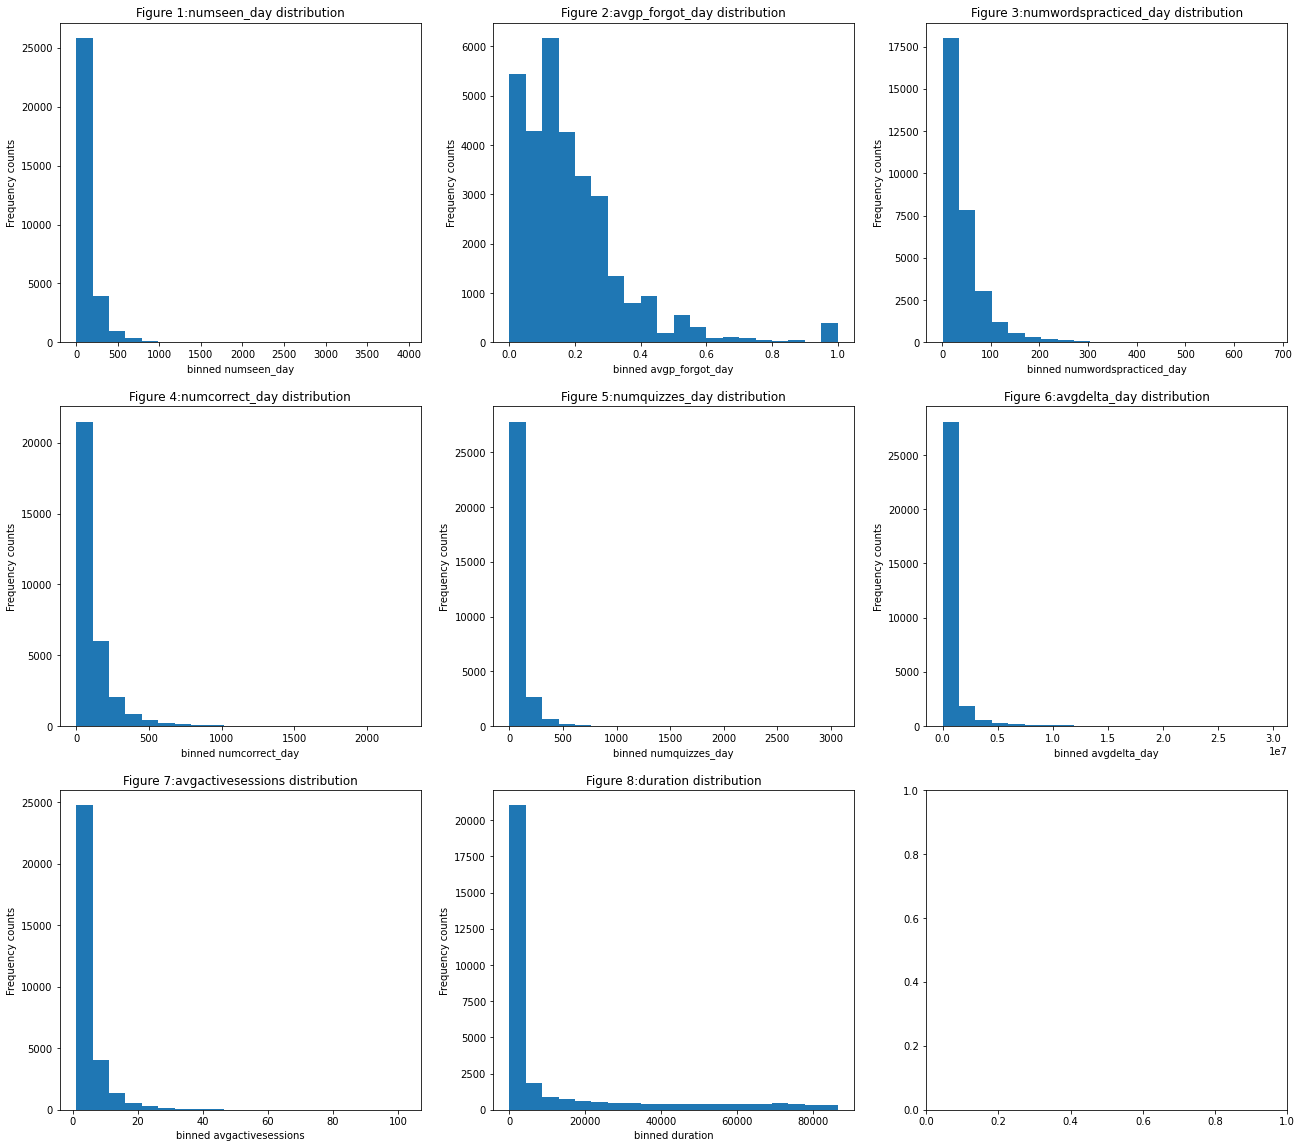

In [ ]:
plt.subplots(3,3,figsize = (22,20))
#plt.suptitle("Distributions of userdates numerical columns")
plot_num = 1
for col in userdates.select_dtypes(exclude= ['object']).columns: # filtering out 'object' datatypes to only numerical columns
  plt.subplot(3,3,plot_num)
  plt.xlabel(f"binned {col}")
  plt.ylabel(f"Frequency counts")
  plt.hist(userdates[col],bins=20)
  plt.title(f"Figure {plot_num}:{col} distribution")
  plot_num +=1

Observations

1. All the columns show distributions heavily skewed to the right. 

They are transformed below to their logarithms, then scaled using minmax scaler. 


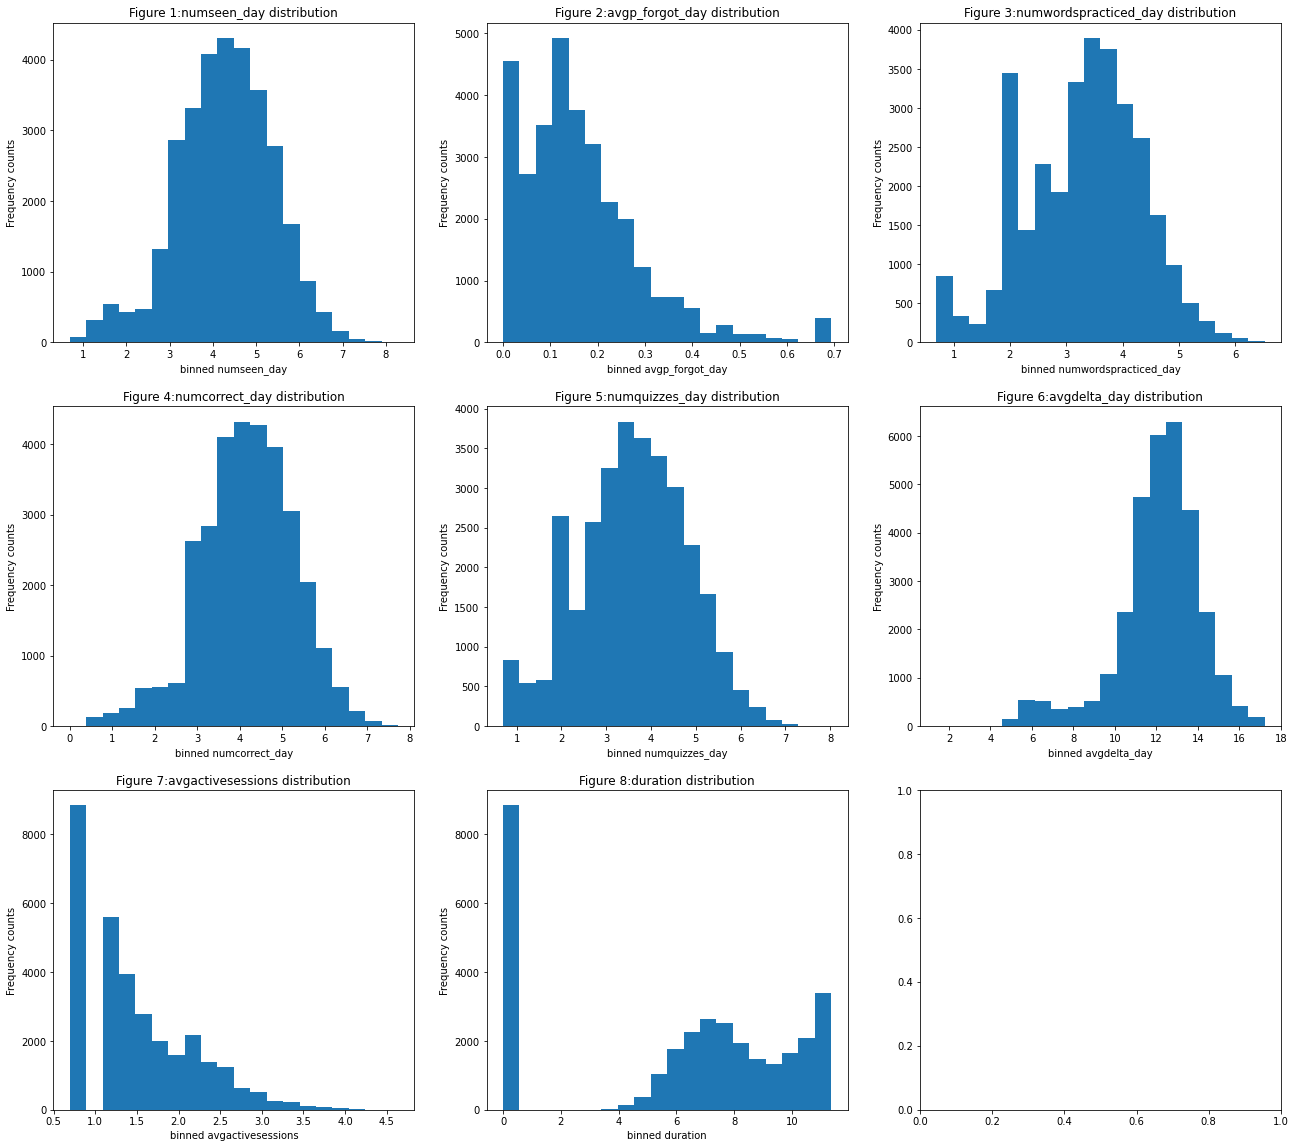

In [ ]:
userdates_tr = userdates.copy()
for col in userdates_tr.columns:
  userdates_tr[col] = np.log(userdates_tr[col]+1)

plt.subplots(3,3,figsize = (22,20))
#plt.suptitle("Distributions of userdates numerical columns")
plot_num = 1
for col in userdates_tr.select_dtypes(exclude= ['object']).columns: # filtering out 'object' datatypes to only numerical columns
  plt.subplot(3,3,plot_num)
  plt.xlabel(f"binned {col}")
  plt.ylabel(f"Frequency counts")
  plt.hist(userdates_tr[col],bins=20)
  plt.title(f"Figure {plot_num}:{col} distribution")
  plot_num +=1

The transformed distributions look a lot more normal shaped. 

The columns are now fit with a minmax scaler. 

Just cluster the average for each user. then scale

In [ ]:
from sklearn.preprocessing import MinMaxScaler 
mmscaler = MinMaxScaler()
userdates_tr_mm = mmscaler.fit_transform(userdates_tr)
userdates_tr_mm = pd.DataFrame(userdates_tr_mm,columns=userdates.columns)
userdates_tr_mm.index = userdates.index

In [ ]:
userdates_tr_mm.head()

numseen_day  avgp_forgot_day  numwordspracticed_day  \
user_id Date                                                              
u:-Md   2013-03-02     0.569916         0.263034               0.518570   
        2013-03-03     0.446059         0.469485               0.334089   
        2013-03-04     0.466695         0.308122               0.345934   
        2013-03-05     0.407396         0.415037               0.119005   
        2013-03-08     0.506036         0.090198               0.491405   

                    numcorrect_day  numquizzes_day  avgdelta_day  \
user_id Date                                                       
u:-Md   2013-03-02        0.640919        0.411839      0.757848   
        2013-03-03        0.514197        0.265327      0.279925   
        2013-03-04        0.538621        0.326956      0.608126   
        2013-03-05        0.484070        0.170816      0.647626   
        2013-03-08        0.581328        0.470410      0.610321   

                    avgactivesessions  duration  
user_id Date                                     
u:-Md   2013-03-02           0.278724  0.703037  
        2013-03-03           0.102869  0.637029  
        2013-03-04           0.175855  0.570783  
        2013-03-05           0.102869  0.462093  
        2013-03-08           0.232468  0.950498

In [ ]:
studentfeatures1 = userdates_tr_mm.transpose().stack().fillna(0)

In [ ]:
studentfeatures1

user_id                    u:-Md     u:-TS      u:-b     u:0P4     u:0Q_  \
            Date                                                           
numseen_day 2013-02-28  0.000000  0.000000  0.000000  0.000000  0.000000   
            2013-03-01  0.000000  0.000000  0.456781  0.000000  0.000000   
            2013-03-02  0.569916  0.000000  0.743598  0.000000  0.487828   
            2013-03-03  0.446059  0.000000  0.822591  0.000000  0.516912   
            2013-03-04  0.466695  0.356918  0.559003  0.000000  0.450453   
...                          ...       ...       ...       ...       ...   
duration    2013-03-07  0.000000  0.000000  0.000000  0.000000  0.000000   
            2013-03-08  0.950498  0.508042  0.773109  0.000000  0.670164   
            2013-03-09  0.000000  0.000000  0.999127  0.000000  0.699945   
            2013-03-10  0.968267  0.571848  0.996958  0.000000  0.831599   
            2013-03-11  0.731707  0.000000  0.999181  0.444846  0.705185   

user_id                    u:0Tt  u:0vf     u:1Qq  u:1kO     u:1nJ  ...  \
            Date                                                    ...   
numseen_day 2013-02-28  0.000000    0.0  0.000000    0.0  0.000000  ...   
            2013-03-01  0.000000    0.0  0.519497    0.0  0.000000  ...   
            2013-03-02  0.000000    0.0  0.446059    0.0  0.000000  ...   
            2013-03-03  0.000000    0.0  0.000000    0.0  0.000000  ...   
            2013-03-04  0.000000    0.0  0.000000    0.0  0.000000  ...   
...                          ...    ...       ...    ...       ...  ...   
duration    2013-03-07  0.000000    0.0  0.613940    0.0  0.000000  ...   
            2013-03-08  0.000000    0.0  0.000000    0.0  0.000000  ...   
            2013-03-09  0.390862    0.0  0.000000    0.0  0.000000  ...   
            2013-03-10  0.000000    0.0  0.000000    0.0  0.000000  ...   
            2013-03-11  0.000000    0.0  0.000000    0.0  0.595286  ...   

user_id                    u:yQy     u:yih     u:yki     u:ylS     u:ynP  \
            Date                                                           
numseen_day 2013-02-28  0.000000  0.000000  0.000000  0.000000  0.000000   
            2013-03-01  0.000000  0.000000  0.212122  0.000000  0.274068   
            2013-03-02  0.000000  0.000000  0.000000  0.000000  0.000000   
            2013-03-03  0.000000  0.000000  0.484533  0.000000  0.000000   
            2013-03-04  0.000000  0.462818  0.426855  0.236152  0.410358   
...                          ...       ...       ...       ...       ...   
duration    2013-03-07  0.682122  0.506388  0.000000  0.000000  0.650618   
            2013-03-08  0.658767  0.536506  0.945455  0.000000  0.000000   
            2013-03-09  0.494161  0.000000  0.954701  0.000000  0.000000   
            2013-03-10  0.000000  0.000000  0.000000  0.000000  0.000000   
            2013-03-11  0.000000  0.391891  0.000000  0.000000  0.529299   

user_id                 u:yva     u:zBA  u:zT8  u:zfs  u:zpJ  
            Date                                              
numseen_day 2013-02-28    0.0  0.000000    0.0    0.0    0.0  
            2013-03-01    0.0  0.000000    0.0    0.0    0.0  
            2013-03-02    0.0  0.418864    0.0    0.0    0.0  
            2013-03-03    0.0  0.000000    0.0    0.0    0.0  
            2013-03-04    0.0  0.000000    0.0    0.0    0.0  
...                       ...       ...    ...    ...    ...  
duration    2013-03-07    0.0  0.000000    0.0    0.0    0.0  
            2013-03-08    0.0  0.000000    0.0    0.0    0.0  
            2013-03-09    0.0  0.000000    0.0    0.0    0.0  
            2013-03-10    0.0  0.000000    0.0    0.0    0.0  
            2013-03-11    0.0  0.862794    0.0    0.0    0.0  

[96 rows x 8087 columns]

In [ ]:
studentfeatures2 = studentfeatures1.transpose()

In [ ]:
studentfeatures2

numseen_day                                                         \
Date     2013-02-28 2013-03-01 2013-03-02 2013-03-03 2013-03-04 2013-03-05   
user_id                                                                      
u:-Md           0.0   0.000000   0.569916   0.446059   0.466695   0.407396   
u:-TS           0.0   0.000000   0.000000   0.000000   0.356918   0.000000   
u:-b            0.0   0.456781   0.743598   0.822591   0.559003   0.610211   
u:0P4           0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
u:0Q_           0.0   0.000000   0.487828   0.516912   0.450453   0.439181   
...             ...        ...        ...        ...        ...        ...   
u:yva           0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
u:zBA           0.0   0.000000   0.418864   0.000000   0.000000   0.556127   
u:zT8           0.0   0.000000   0.000000   0.000000   0.000000   0.356918   
u:zfs           0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
u:zpJ           0.0   0.000000   0.000000   0.000000   0.000000   0.000000   

                                                     ...   duration  \
Date    2013-03-06 2013-03-07 2013-03-08 2013-03-09  ... 2013-03-02   
user_id                                              ...              
u:-Md     0.000000   0.000000   0.506036   0.000000  ...   0.703037   
u:-TS     0.282059   0.000000   0.352450   0.000000  ...   0.000000   
u:-b      0.731363   0.000000   0.673357   0.648449  ...   0.991083   
u:0P4     0.000000   0.053440   0.000000   0.000000  ...   0.000000   
u:0Q_     0.661708   0.000000   0.515601   0.554174  ...   0.623635   
...            ...        ...        ...        ...  ...        ...   
u:yva     0.000000   0.000000   0.000000   0.443806  ...   0.000000   
u:zBA     0.000000   0.373415   0.000000   0.000000  ...   0.000000   
u:zT8     0.000000   0.000000   0.000000   0.000000  ...   0.000000   
u:zfs     0.000000   0.000000   0.000000   0.000000  ...   0.000000   
u:zpJ     0.000000   0.000000   0.000000   0.000000  ...   0.000000   

                                                                           \
Date    2013-03-03 2013-03-04 2013-03-05 2013-03-06 2013-03-07 2013-03-08   
user_id                                                                     
u:-Md     0.637029   0.570783   0.462093   0.000000        0.0   0.950498   
u:-TS     0.000000   0.522382   0.000000   0.000000        0.0   0.508042   
u:-b      0.999327   0.482914   0.646525   0.987806        0.0   0.773109   
u:0P4     0.000000   0.000000   0.000000   0.000000        0.0   0.000000   
u:0Q_     0.687862   0.623341   0.598667   0.731664        0.0   0.670164   
...            ...        ...        ...        ...        ...        ...   
u:yva     0.000000   0.000000   0.000000   0.000000        0.0   0.000000   
u:zBA     0.000000   0.000000   0.888242   0.000000        0.0   0.000000   
u:zT8     0.000000   0.000000   0.000000   0.000000        0.0   0.000000   
u:zfs     0.000000   0.000000   0.000000   0.000000        0.0   0.000000   
u:zpJ     0.000000   0.000000   0.000000   0.000000        0.0   0.000000   

                                          
Date    2013-03-09 2013-03-10 2013-03-11  
user_id                                   
u:-Md     0.000000   0.968267   0.731707  
u:-TS     0.000000   0.571848   0.000000  
u:-b      0.999127   0.996958   0.999181  
u:0P4     0.000000   0.000000   0.444846  
u:0Q_     0.699945   0.831599   0.705185  
...            ...        ...        ...  
u:yva     0.000000   0.000000   0.000000  
u:zBA     0.000000   0.000000   0.862794  
u:zT8     0.000000   0.000000   0.000000  
u:zfs     0.000000   0.000000   0.000000  
u:zpJ     0.000000   0.000000   0.000000  

[8087 rows x 96 columns]

In [ ]:
newcolumns = [str(x[0])+'_'+str(x[1]) for x in studentfeatures2.columns]

In [ ]:
studentfeatures2.columns = newcolumns
studentfeatures2.head()

,numseen_day_2013-02-28,numseen_day_2013-03-01,numseen_day_2013-03-02,numseen_day_2013-03-03,numseen_day_2013-03-04,numseen_day_2013-03-05,numseen_day_2013-03-06,numseen_day_2013-03-07,numseen_day_2013-03-08,numseen_day_2013-03-09,...,duration_2013-03-02,duration_2013-03-03,duration_2013-03-04,duration_2013-03-05,duration_2013-03-06,duration_2013-03-07,duration_2013-03-08,duration_2013-03-09,duration_2013-03-10,duration_2013-03-11
user_id,,,,,,,,,,,,,,,,,,,,,
u:-Md,0.0,0.000000,0.569916,0.446059,0.466695,0.407396,0.000000,0.00000,0.506036,0.000000,...,0.703037,0.637029,0.570783,0.462093,0.000000,0.0,0.950498,0.000000,0.968267,0.731707
u:-TS,0.0,0.000000,0.000000,0.000000,0.356918,0.000000,0.282059,0.00000,0.352450,0.000000,...,0.000000,0.000000,0.522382,0.000000,0.000000,0.0,0.508042,0.000000,0.571848,0.000000
u:-b,0.0,0.456781,0.743598,0.822591,0.559003,0.610211,0.731363,0.00000,0.673357,0.648449,...,0.991083,0.999327,0.482914,0.646525,0.987806,0.0,0.773109,0.999127,0.996958,0.999181
u:0P4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05344,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.444846
u:0Q_,0.0,0.000000,0.487828,0.516912,0.450453,0.439181,0.661708,0.00000,0.515601,0.554174,...,0.623635,0.687862,0.623341,0.598667,0.731664,0.0,0.670164,0.699945,0.831599,0.705185



Now we will join the studentfeatures to the Mar 12 dataset. Then we will join the word features, then split, then convert to sparse arrays.  

In [ ]:
compressed_pickle(path_name+"studentfeatures2",studentfeatures2)

## Clustering

In [ ]:
studentfeatures2.shape

(8087, 96)

In [ ]:
from sklearn.cluster import MiniBatchKMeans



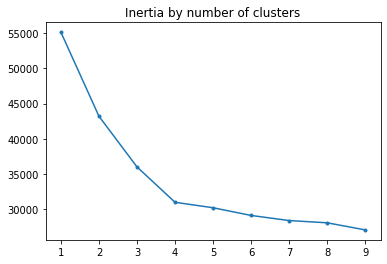

In [ ]:
inertias = []
for k in range(1,10):
  km_model = MiniBatchKMeans(n_clusters=k)
  km_model.fit(studentfeatures2)
  inertias.append(km_model.inertia_)
  
plt.figure()
plt.title("Inertia by number of clusters")
plt.plot(range(1,10),inertias,'.-')
plt.show()

In [ ]:
mbKmeans = MiniBatchKMeans(n_clusters=4)

mbKmeans.fit(studentfeatures2)

studentfeatures2['label'] = mbKmeans.labels_

studentfeatures2['label'].value_counts()

0    3358
1    2984
2    1123
3     622
Name: label, dtype: int64

In [ ]:
from sklearn.metrics import silhouette_score

ks = np.arange(2,10)

sil_scores = []

for k in ks:
    
    kmeans = MiniBatchKMeans(n_clusters = k)
    kmeans.fit(studentfeatures2)
    
    sil_scores.append(silhouette_score(studentfeatures2,kmeans.labels_))
    

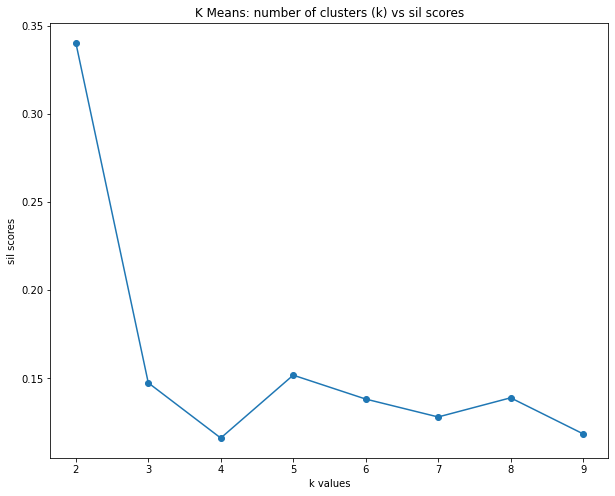

In [ ]:
# plot sil score
plt.figure(figsize = (10,8))
plt.plot(ks,sil_scores,marker = 'o')
plt.xlabel('k values')
plt.ylabel('sil scores')
plt.title('K Means: number of clusters (k) vs sil scores')
plt.show()

Getting Mar 12 dataset

In [ ]:
lastdayq2 = datadfq2.loc[(datadfq2['Date']==datetime.strptime('12032013', "%d%m%Y").date()),:]

In [ ]:
lastdayq2.shape

(492966, 22)

In [ ]:
lastdayq2wstfeatures = pd.merge(left = lastdayq2,right = studentfeatures2,left_on='user_id',right_on = 'user_id',how="left")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
lastdayq2wstfeatures.shape

(492966, 142)

Now we get q1lexeme features and attach them, then we get rid of unnecessary columns. then we split by students into train and test. 

In [ ]:
lastdayq2

,p_recall,timestamp,delta,user_id,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,...,"(duration, 2013-03-02)","(duration, 2013-03-03)","(duration, 2013-03-04)","(duration, 2013-03-05)","(duration, 2013-03-06)","(duration, 2013-03-07)","(duration, 2013-03-08)","(duration, 2013-03-09)","(duration, 2013-03-10)","(duration, 2013-03-11)"
0,1.0,1363046401,1123854,u:inBD,4452601308c9aeb4f25f01fb6710ed16,salsa/salsa<n><f><sg>,2,2,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
1,1.0,1363046401,1125308,u:inBD,bdb10c2d4f793986f32986d746051a59,fresas/fresa<n><f><pl>,3,3,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
2,0.0,1363046401,1123854,u:inBD,890f121972386ce1dbb811304e774f3f,comida/comida<n><f><sg>,2,2,1,0,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
3,1.0,1363046401,73543,u:inBD,a52bc2771bde31d4d5e80bd29f350714,manzana/manzana<n><f><sg>,6,6,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
4,1.0,1363046401,1125985,u:inBD,08bb4120ecb09c3cc4a544af3f119f6d,pasta/pasta<n><f><sg>,3,3,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0


numseen_day: how many individual questions were done in the day
avgp_recall_day: the average number of questions answered correctly (should word out to be derivable)
numwordspraciced_day: how many individual words were practiced in that day.
numcorrect_day: how many questions were asnwered correctly in that day
numsessions_day: how many individual sessions


As EDA, we can try to cluster the students based on their behavior. or look at their performance on certain words, and what separates students who forget vs students who don't for around the same delta and history seen. 

For now, we can add the previous learning day's features to each record of the next learning day. if there is none, maybe we can impute the total average although that would be data leakage. maybe do a time based split?

1. get all users up to first 10 days or so, then see if you can predict performance on the next 4 days?

Clustering students:

We may have to look at features for only a subset of the data where we have enough - but this would disproportionately get rid of 'irregular' students. so we shouldn't.

numseen_day: number of questions seen that day
avgp_recall_day - average p_recall per word-session (not the same as numcorrect_day/numseen_day)
numwordspracticed_day: number of unique words practiced that day
numcorrect_day : number of questions answered correctly that day
numquizzes_day: number of quizzes taken per word (number of records that day)
avgdelta_day: the average interval since the last quiz - this is an aggregate measure of the choice made by the student - if avgdelta is low, then they mostly reviewed recent words, if avgdelta is high, then they mostly reviewed words that were learned a while ago. 
avgactivesessions - might be an artefact of how timestamps are recorded, but essentially the number of unique timestamps - if this number is high, student was active during 


In [ ]:
310/446

0.695067264573991

In [ ]:
lexemeids = datadfq1['lexeme_id']
lexemeids = pd.DataFrame(lexemeids)

Getting q1lexemes, getting indices of lexeme id. then joining just those. 

In [ ]:
q1lexemes = decompress_pickle(path_name+"q1_lexeme_features.pbz2")

In [ ]:
q1lexemes.shape

(12160, 2292)

In [ ]:
q1lexemeids=pd.DataFrame(q1lexemes['lexeme_id'])

In [ ]:
q1lexemeids = q1lexemeids.reset_index()
q1lexemeids.head()

,index,lexeme_id
0,0,73eecb492ca758ddab5371cf7b5cca32
1,1,c84476c460737d9fb905dca3d35ec995
2,2,1a913f2ded424985b9c02d0436008511
3,3,38b770e66595fea718366523b4f7db3f
4,4,4bdb859f599fa07dd5eecdab0acc2d34


In [ ]:
lexemeids.shape, q1lexemeids.shape

((7313354, 1), (12160, 2))

Now we will map the main dataframe indices to the lexeme features indices.

In [ ]:
lexeme_map = pd.merge(left=lexemeids,right=q1lexemeids, how='left',left_on = 'lexeme_id',right_on = 'lexeme_id')

In [ ]:
lexeme_map.head()

,lexeme_id,index
0,73eecb492ca758ddab5371cf7b5cca32,0
1,73eecb492ca758ddab5371cf7b5cca32,0
2,c84476c460737d9fb905dca3d35ec995,1
3,1a913f2ded424985b9c02d0436008511,2
4,38b770e66595fea718366523b4f7db3f,3


index column here contains the row of the q1lexemes dataframe that needs to be concatenated to the main dataframe.


Row-wise concatenation using getrow() was taking too long (see below commented cells), so we will instead convert q1lexemes to a coo matrix - > get a dictionary of keys, and use that to construct the bigger matrix. 

There are still some non-numeric columns that need to be converted to binaries or deleted. we will do this first. 

In [ ]:
compressed_pickle(path_name+"lexeme_map",lexeme_map)

In [ ]:
q1lexemes.select_dtypes('object').head()

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings
0,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo,pr,[]
1,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño,n,"[m, pl]"
2,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer,vblex,"[pri, p1, sg]"
3,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro,n,"[m, sg]"
4,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a,pr,[]


Converting pos to binaries. 

In [ ]:
pos_dummies = pd.get_dummies(q1lexemes['pos'],prefix='pos')
q1lexemes = pd.concat([q1lexemes,pos_dummies],axis=1)

In [ ]:
q1lexemes['pos']

,pos,pos,pos
0,pr,0.0,0.0
1,n,0.0,0.0
2,vblex,0.0,0.0
3,n,0.0,0.0
4,pr,0.0,0.0
...,...,...,...
12155,vblex,0.0,0.0
12156,n,0.0,0.0
12157,n,0.0,0.0
12158,vblex,0.0,0.0


In [ ]:
q1lexemes['pos1'] = pd.Series([q1lexemes['pos'].loc[i][1] for i in range(q1lexemes['pos'].shape[0])])

In [ ]:
q1lexemes = q1lexemes.drop(['lexeme_id','lexeme_string','learning_language','surface_form','lemma_form','pos','modstrings'],axis=1)

In [ ]:
q1lexemes.select_dtypes('object')

""
0
1
2
3
4
...
12155
12156
12157
12158


No strings left in the q1lexemes dataframe. We can now convert to coo matrix. 

In [ ]:
q1lexemes.size/1000000

27.87072

In [ ]:
q1lexemecoo = coo_matrix(np.array(q1lexemes))

In [ ]:
q1lexemecoo.size/1000000

0.151624

Failed attempt at row-wise concatenation:

In [ ]:
#Very sparse matrix. now we will index a row.
#q1lexemecoo.getrow(0)

#Will go row_wise in lexeme_map, and get the row from the indices, and concatenate. 
# from scipy.sparse import hstack

# lexemes_coo  = q1lexemecoo.getrow(lexeme_map.iloc[0,1])

# for i,row in lexeme_map.tail(-1).iterrows():
#   if i%1000 == 0:
#     print(i,' rows done',end='\r')
#   lexemes_coo = hstack((lexemes_coo,q1lexemecoo.getrow(row['index'])))
# lexemes_coo.shape

<1x2291 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

Converting to dictionary of keys

In [ ]:
q1lexemecoo_dok = q1lexemecoo.todok(copy=True)

Let's look at the first 10 values of the ductionary. 

In [ ]:
list(q1lexemecoo_dok.items())[0:10]

[((0, 0), 7.0),
 ((0, 1), 4.0),
 ((0, 87), 1.0),
 ((0, 141), 0.35263237459267294),
 ((0, 144), 0.4122115155582215),
 ((0, 275), 0.28469397919105377),
 ((0, 276), 0.3929244102341387),
 ((0, 1027), 0.32488787493717813),
 ((0, 2280), 1.0),
 ((1, 0), 20.0)]

We can return the first row as: 

In [ ]:
list(q1lexemecoo_dok[0].items())

[((0, 0), 7.0),
 ((0, 1), 4.0),
 ((0, 87), 1.0),
 ((0, 141), 0.35263237459267294),
 ((0, 144), 0.4122115155582215),
 ((0, 275), 0.28469397919105377),
 ((0, 276), 0.3929244102341387),
 ((0, 1027), 0.32488787493717813),
 ((0, 2280), 1.0)]

We can create a new coo matrix from a dictionary of keys we defined.

In [ ]:
keyvals = [(key,val) for (key,val) in q1lexemecoo_dok[0].items()]
vals = [val for (key,val) in keyvals]
rows = [key[0] for (key,val) in keyvals]
cols = [key[1] for (key,val) in keyvals]

coo = coo_matrix((vals, (rows, cols)))

spmatrix = coo.toarray()
spmatrix

array([[7., 4., 0., ..., 0., 0., 1.]])

add a row to a dictionary, with the row number updated with the main dataframe row. 

In [ ]:
vals = []
rows = []
cols = []

count = 0
for i in lexeme_map['index']:
  if count%1000 == 0:
    print(count," rows done")
  keyvals = [(key,val) for (key,val) in q1lexemecoo_dok[i].items()]
  vals = vals + [val for (key,val) in keyvals]
  cols = cols + [key[1] for (key,val) in keyvals]
  rows = rows + [i]*len(keyvals)
  count +=1 

0  rows done
1000  rows done
2000  rows done
3000  rows done
4000  rows done
5000  rows done
6000  rows done
7000  rows done
8000  rows done
9000  rows done
10000  rows done
11000  rows done
12000  rows done
13000  rows done
14000  rows done
15000  rows done
16000  rows done
17000  rows done
18000  rows done
19000  rows done
20000  rows done
21000  rows done
22000  rows done
23000  rows done
24000  rows done
25000  rows done
26000  rows done
27000  rows done
28000  rows done
29000  rows done
30000  rows done
31000  rows done
32000  rows done
33000  rows done
34000  rows done
35000  rows done
36000  rows done
37000  rows done
38000  rows done
39000  rows done
40000  rows done


KeyboardInterrupt: ignored

We can construct the dictionary so that we use the 'index' column in the main dataframe change the row numbers to match the row of the main dataframe. 

The pseudocode is below:

initialize a dictionary that will be the sparse matrix:
word_features = dict()

For each row in the lexemes dataframe:<br>
  >indexnumbers = Get the rows of the main dataframe with that word from the 'index' column<br>
  >for each number in indexnumbers:<br>
  >>copy the row of q1lexemes, and change the row number to be same as main dataframe row. 
    
Convert the dictionary to a sparse matrix. 

Another alternative is to get counts of p_forgot_bin and number of sessions for each word, and model just the word features. this is another possibility for reducing size: feature selection. 

Pseudocode:
transform delta for finer granularity, and get bins, 
groupby the lexeme_id, and bins and get p_forgot counts for 1 and 0. also num students for each delta? and total? should we also get bin by history correct/ history and group by both delta and fraction history correct? 

table:
lexeme id, lexeme id features, p_forgot_1_counts list, p_forgot_0_counts list, delta_bins_list, history_frac_list 